In [180]:
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

file_path = '~/Desktop/pcparts/datatables/'

In [181]:
#Function to convert from single size measurements to numbers:
def size_to_num(df, column_str):
    list_val=[]

    for i in range(1, df.shape[0]+1):
        if type(df[column_str][i])==int:
            list_val.append(0)
        else:
            list_val.append(float(re.search('[0-9]{1,2}\.[0-9]+', df[column_str][i]).group(0)))

    return list_val

In [182]:
#Function to grab compatible COOLERS based on CPU socket
def socket_filter(socket):
    return [True if re.search(socket, x) else False for x in cooler['supported sockets']]

In [183]:
#Function to convert from cross-fire/sli words to numeric values
def sli_cross_num(df, column_str):
    list_val=[]
    
    for x in df[column_str]:
        if x == 'No':
            list_val.append(1)
        elif x == 'Yes':
            list_val.append(2)
        else:
            try:
                re.search('(4-way)', x).group(1)
                list_val.append(4)
            except:
                list_val.append(3)
            
    return list_val

In [184]:
#Function to convert range values into [min, max] or [0, only value] list
def limit_finder(df, column_str, ret_type, exp_groups):
    min_list = []
    max_list = []
    
    for el in df[column_str]:
        limit_search = re.search('([0-9]{1,3}[\.]?[0-9])(\s-\s)?([0-9]{1,4}[\.]?[0-9]?)?', el)
        try:
            if limit_search.group(exp_groups) == None:
                min_list.append(ret_type(0))
                max_list.append(ret_type(limit_search.group(1)))
            else:
                min_list.append(ret_type(limit_search.group(1)))
                max_list.append(ret_type(limit_search.group(exp_groups)))
        except:
            min_list.append(ret_type(0))
            max_list.append(ret_type(0))
        
    return [min_list, max_list]

In [185]:
#Take in RAM speed, type and output compatible mobos:
def mobo_ram_compatibility(mem_speed):
    mem_type = int(re.search('^DDR([234])', mem_speed).group(1))
    temp_bool_type = [mem_type == x for x in motherboard['DDR type']]
    
    mem_n = re.search('([0-9]{2,4})', mem_speed).group(1)
    temp_bool_n = [(mem_n in x) for x in motherboard['memory type']]
    return ([a and b for a, b in zip(temp_bool_type, temp_bool_n)])

In [186]:
#Use mobo-psu dictionary to find compatible psu's for given mobo
def mobo_psu_bool(mobo_type):
    psu_comps = mobo_psu_dict[mobo_type]
    for i in range(0, len(psu_comps)):
        bool1 = [bool(re.match(psu_comps[i], x)) for x in psu_type1]
        bool2 = [bool(re.match(psu_comps[i], x)) for x in psu_type2]
        run_bool = [a or b for a, b in zip(bool1, bool2)]
        
        if i > 0:
            run_bool = [a or b for a, b in zip(run_bool, temp_bool)]
        
        temp_bool = run_bool[:]

    return run_bool

mobo_psu_dict = {'Micro ATX':['Micro ATX', 'ATX', 'SFX', 'TFX', 'Flex ATX'],
                 'Mini ITX':['Mini ITX', 'SFX', 'TFX', 'Flex ATX'],
                 'ATX':['ATX', 'EPS'],
                 'EATX':['EPS']}

## Setup for usage ##
# Choice of Motherboard type
mobo_type = 'Mini ITX'
print 'Choice of mobo type:\n{}\n'.format(mobo_type)

# Compatible PSU types
print 'Compatible PSU types:\n{}\n'.format(mobo_psu_dict[mobo_type])

psu_type1 = [re.search('([A-Za-z]{1,5})(12V\s/\s)?([A-Za-z]{1,5})?', x).group(1) for x in psu['type']]

psu_type2 = []
for i in range(1, len(psu['type'])+1):
    try:
        psu_type2.append(str(re.search('([A-Za-z]{1,5})(12V\s/\s)?([A-Za-z]{1,5})?', psu['type'][i]).group(3)))
    except: 
        psu_type2.append('')

Choice of mobo type:
Mini ITX

Compatible PSU types:
['Mini ITX', 'SFX', 'TFX', 'Flex ATX']



## Import all files and fill in NAs with 0s

In [187]:
case = pd.read_csv('{}case_dt.csv'.format(file_path), sep=',', engine='python', index_col=0)
case.fillna(value=0, inplace=True)
case['prod_price'] = case['prod_price'][case['prod_price'] > 0]
case.head()

,color,manufacturer,part #,type,model,motherboard compatibility,"internal 2.5"""" bays","internal 3.5"""" bays","external 5.25"""" bays","external 3.5"""" bays",includes power supply,maximum video card length,prod_type,rating_val,rating_n,prod_name,prod_price,front panel usb 3.0 ports,dimensions
1,Black/Red,NZXT,CA-S340W-BR1,ATX Mid Tower,S340 (Black/Red),ATX-Micro ATX-Mini ITX,2.0,3.0,0.0,0.0,No,"13.15"""" (334mm) With Drive Cages",Case,4.7,56,NZXT S340 (Black/Red) ATX Mid Tower Case,64.98,Yes,
2,Black,Azza,CSAZ-206S,ATX Mid Tower,SIRIUS,ATX-Micro ATX,0.0,3.0,3.0,0.0,No,0,Case,4.3,10,Azza SIRIUS ATX Mid Tower Case,19.98,No,"16.97"" x 7.87"" x 17.48"""
3,Black/Blue,Deepcool,TESSERACT SW,ATX Mid Tower,0,ATX-Micro ATX-Mini ITX,0.0,4.0,2.0,0.0,No,"12.20""""",Case,4.3,46,Deepcool TESSERACT SW ATX Mid Tower Case,39.98,Yes,"16.93"" x 7.64"" x 17.17"""
4,White,NZXT,CA-S340W-W1,ATX Mid Tower,S340 (White),ATX-Micro ATX-Mini ITX,2.0,3.0,0.0,0.0,No,"13.15"""" (334mm) With Drive Cages",Case,4.6,121,NZXT S340 (White) ATX Mid Tower Case,64.98,Yes,
5,Black,Corsair,200R,ATX Mid Tower,0,ATX-Micro ATX-Mini ITX,4.0,4.0,3.0,0.0,No,"11.81"""" (300mm) With Drive Cages",Case,4.6,182,Corsair 200R ATX Mid Tower Case,54.98,Yes,"19.57"" x 8.27"" x 16.89"""


In [188]:
cpu = pd.read_csv('{}cpu_dt.csv'.format(file_path), sep=',', engine='python', index_col=0)
cpu.fillna(value=0, inplace=True)
cpu['prod_price'] = cpu['prod_price'][cpu['prod_price'] > 0]
cpu.head(2)

,manufacturer,part #,model,data width,socket,operating frequency,max turbo frequency,cores,l1 cache,l2 cache,...,includes cpu cooler,hyper-threading,maximum supported memory,integrated graphics,prod_type,rating_val,rating_n,prod_name,prod_price,l2 cache-2
1,Intel,BX80677I77700K,0,64-bit,LGA1151,4.2GHz,4.5GHz,4,4 x 32KB Instruction,4 x 256KB,...,No,Yes,64GB,Intel HD Graphics 630,CPU,4.8,80,Intel Core i7-7700K 4.2GHz Quad-Core Processor,338.33,4 x 32KB
2,Intel,BX80677I57600K,0,64-bit,LGA1151,3.8GHz,4.2GHz,4,4 x 32KB Instruction,4 x 256KB,...,No,No,64GB,Intel HD Graphics 630,CPU,4.9,42,Intel Core i5-7600K 3.8GHz Quad-Core Processor,228.88,4 x 32KB


In [189]:
cooler = pd.read_csv('{}cooler_dt.csv'.format(file_path), sep=',', engine='python', index_col=0)
cooler.fillna(value=0, inplace=True)
cooler['prod_price'] = cooler['prod_price'][cooler['prod_price'] > 0]
cooler.head(2)

,manufacturer,part #,model,height,prod_type,rating_val,rating_n,prod_name,prod_price,radiator size,noise level,supported sockets,fan rpm,liquid cooled
1,Cooler Master,RR-212E-20PK-R2,Hyper 212 EVO,"6.26"""" (159mm)",CPU Cooler,4.6,1234,Cooler Master Hyper 212 EVO 82.9 CFM Sleeve Be...,24.87,,9.0 - 36.0 dbA,AM2-AM2+-AM3-AM3+-AM4-FM1-FM2-FM2+-LGA1150-LG...,600 - 2000 RPM,No
2,Corsair,CW-9060025-WW,H100i v2,0,CPU Cooler,4.6,157,Corsair H100i v2 70.7 CFM Liquid CPU Cooler,119.88,240mm,37.7 dbA,AM2-AM2+-AM3-AM3+-AM4-FM1-FM2-FM2+-LGA1150-LG...,2435 RPM,Yes


In [190]:
gpu = pd.read_csv('{}gpu_dt.csv'.format(file_path), sep=',', engine='python', index_col=0)
gpu.fillna(value=0, inplace=True)
gpu['prod_price'] = gpu['prod_price'][gpu['prod_price'] > 0]
gpu.head()

,manufacturer,part #,model,interface,chipset,sli support,memory size,memory type,crossfire support,core clock,...,mini-hdmi,displayport,length,tdp,supports g-sync,prod_type,rating_val,rating_n,prod_name,prod_price
1,MSI,GEFORCE GTX 1060 GAMING X 6G,0,PCI-Express x16,GeForce GTX 1060 6GB,No,6GB,GDDR5,No,1.51GHz,...,0.0,3.0,"10.91"""" (277mm)",120 Watts,Yes,Video Card,4.8,30,MSI GeForce GTX 1060 6GB 6GB GAMING X Video Card,259.98
2,EVGA,04G-P4-6255-KR,0,PCI-Express x16,GeForce GTX 1050 Ti,No,4GB,GDDR5,No,1.37GHz,...,0.0,1.0,"9.02"""" (229mm)",75 Watts,Yes,Video Card,5.0,2,EVGA GeForce GTX 1050 Ti 4GB SSC GAMING ACX 3....,119.98
3,Asus,ROG STRIX-GTX1070-O8G-GAMING,0,PCI-Express x16,GeForce GTX 1070,Yes,8GB,GDDR5,No,1.63GHz,...,0.0,2.0,"11.73"""" (298mm)",150 Watts,Yes,Video Card,4.9,63,Asus GeForce GTX 1070 8GB Video Card,389.98
4,EVGA,06G-P4-6163-KR,0,PCI-Express x16,GeForce GTX 1060 6GB,No,6GB,GDDR5,No,1.61GHz,...,0.0,3.0,"6.81"""" (173mm)",120 Watts,Yes,Video Card,4.9,16,EVGA GeForce GTX 1060 6GB 6GB SC GAMING Video ...,209.98
5,EVGA,04G-P4-6253-KR,0,PCI-Express x16,GeForce GTX 1050 Ti,No,4GB,GDDR5,No,1.35GHz,...,0.0,1.0,"5.71"""" (145mm)",75 Watts,Yes,Video Card,4.9,7,EVGA GeForce GTX 1050 Ti 4GB SC GAMING ACX 2.0...,142.97


In [191]:
memory = pd.read_csv('{}memory_dt.csv'.format(file_path), sep=',', engine='python', index_col=0)
memory.fillna(value=0, inplace=True)
memory['prod_price'] = memory['prod_price'][memory['prod_price'] > 0]
memory.head()

,color,manufacturer,part #,type,price/gb,speed,size,cas latency,voltage,heat spreader,ecc,registered,prod_type,rating_val,rating_n,prod_name,prod_price
1,Green,Kingston,KVR1333D3N9/8G,240-pin DIMM,$6.62,DDR3-1333,8GB (1 x 8GB),9,1.5V,No,No,No,Memory,4.5,4,Kingston 8GB (1 x 8GB) DDR3-1333 Memory,52.98
2,Black/Red,G.Skill,F3-2133C9D-16GTX,240-pin DIMM,$6.87,DDR3-2133,16GB (2 x 8GB),9,1.6V,Yes,No,No,Memory,5.0,7,G.Skill Trident X 16GB (2 x 8GB) DDR3-2133 Memory,109.98
3,Black/Red,Corsair,CMY16GX3M2C1600C9R,240-pin DIMM,$7.50,DDR3-1600,16GB (2 x 8GB),11,1.35V,Yes,No,No,Memory,5.0,1,Corsair Vengeance Pro 16GB (2 x 8GB) DDR3-1600...,119.98
4,Black/Gold,Team,TPD44GM2133HC1501,288-pin DIMM,$8.49,DDR4-2133,4GB (1 x 4GB),15,1.2V,Yes,No,No,Memory,5.0,1,Team Elite Plus 4GB (1 x 4GB) DDR4-2133 Memory,33.97
5,Black/Silver,Corsair,CMD16GX4M4A2666C15,288-pin DIMM,$11.87,DDR4-2666,16GB (4 x 4GB),15,1.2V,Yes,No,No,Memory,4.8,4,Corsair DOMINATOR Platinum 16GB (4 x 4GB) DDR4...,189.98


In [192]:
motherboard = pd.read_csv('{}motherboard_dt.csv'.format(file_path), sep=',', engine='python', index_col=0)
motherboard.fillna(value=0, inplace=True)
motherboard['prod_price'] = motherboard['prod_price'][motherboard['prod_price'] > 0]
motherboard['maximum supported memory'][motherboard['maximum supported memory'] == 0] = '1TB'
motherboard = motherboard[~(motherboard['cpu socket'] == 0)]
motherboard.head()

/Users/samo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,manufacturer,part #,model,maximum supported memory,form factor,chipset,sli support,memory type,crossfire support,cpu socket,...,sata express,onboard ethernet,onboard usb 3.0 header(s),u.2,onboard video,prod_type,rating_val,rating_n,prod_name,prod_price
1,Asus,STRIX Z270-E GAMING,0,64GB,ATX,Intel Z270,Yes,DDR4-2133 / 2400 / 2666 / 2800 / 3000 / 3200 /...,Yes,LGA1151,...,0.0,1 x 10/100/1000 Mbps,Yes,0.0,Depends on CPU,Motherboard,4.8,16,Asus STRIX Z270-E GAMING ATX LGA1151 Motherboard,186.98
2,MSI,B350M GAMING PRO,0,32GB,Micro ATX,AMD B350,No,DDR4-1866 / 2133 / 2400 / 2666 / 2933 / 3200,No,AM4,...,0.0,1 x 10/100/1000 Mbps,Yes,0.0,Depends on CPU,Motherboard,4.0,1,MSI B350M GAMING PRO Micro ATX AM4 Motherboard,78.87
3,MSI,B150M BAZOOKA,0,64GB,Micro ATX,Intel B150,No,DDR4-2133,No,LGA1151,...,1.0,1 x 10/100/1000 Mbps,Yes,0.0,Depends on CPU,Motherboard,4.4,14,MSI B150M BAZOOKA Micro ATX LGA1151 Motherboard,41.97
4,MSI,Z170A GAMING M5,0,64GB,ATX,Intel Z170,Yes,DDR4-2133 / 2400 / 2800 / 3000 / 3200,Yes,LGA1151,...,2.0,1 x 10/100/1000 Mbps,Yes,0.0,Depends on CPU,Motherboard,4.7,49,MSI Z170A GAMING M5 ATX LGA1151 Motherboard,123.97
5,Gigabyte,GA-B250M-DS3H,0,64GB,Micro ATX,Intel B250,No,DDR4-2133 / 2400,No,LGA1151,...,0.0,1 x 10/100/1000 Mbps,Yes,0.0,Depends on CPU,Motherboard,4.0,5,Gigabyte GA-B250M-DS3H Micro ATX LGA1151 Mothe...,69.88


In [193]:
psu = pd.read_csv('{}psu_dt.csv'.format(file_path), sep=',', engine='python', index_col=0)
psu.fillna(value=0, inplace=True)
psu['prod_price'] = psu['prod_price'][psu['prod_price'] > 0]
psu.head()

,manufacturer,part #,type,model,wattage,modular,efficiency,efficiency certification,output,pci-express 6+2-pin connectors,fans,prod_type,rating_val,rating_n,prod_name,prod_price
1,EVGA,120-G1-0650-XR,ATX12V / EPS12V,SuperNOVA 650,650 Watts,Full,90% Typical,80+ Gold,+3.3V@25A-+5V@25A-+12V1@20A-+12V2@20A-+12V3@20...,4.0,1,Power Supply,4.7,194,EVGA SuperNOVA NEX 650W 80+ Gold Certified Ful...,74.88
2,EVGA,100-B1-0500-KR,ATX12V / EPS12V,500B,500 Watts,No,< 85%,80+ Bronze,0,2.0,1,Power Supply,4.5,147,EVGA 500W 80+ Bronze Certified ATX Power Supply,36.87
3,Corsair,CP-9020101-NA,ATX,CX450M,450 Watts,Semi,0,80+ Bronze,0,2.0,1,Power Supply,4.5,27,Corsair CXM 450W 80+ Bronze Certified Semi-Mod...,32.97
4,EVGA,220-G2-0750-XR,ATX12V / EPS12V,SuperNOVA 750,750 Watts,Full,90% Typical,80+ Gold,+5V@24A +3.3V@24A +12V@62.4A<br/>-12V@0.5A +5V...,4.0,1,Power Supply,4.9,250,EVGA SuperNOVA G2 750W 80+ Gold Certified Full...,99.98
5,EVGA,220-G2-0850-XR,ATX,SuperNOVA 850,850 Watts,Full,90% Typical,80+ Gold,+5V@24A +3.3V@24A +12V@70.8A -12V@0.5A +5Vsb@2.5A,4.0,1,Power Supply,4.9,132,EVGA SuperNOVA G2 850W 80+ Gold Certified Full...,96.97


In [444]:
storage = pd.read_csv('{}storage_dt.csv'.format(file_path), sep=',', engine='python', index_col=0)
storage.fillna(value=0, inplace=True)
storage.head()

,manufacturer,part #,model,capacity,interface,form factor,price/gb,prod_type,rating_val,rating_n,prod_name,prod_price,cache,nand flash type
1,ADATA,ASP550SS3-480GM-C,0,480GB,SATA 6 Gb/s,"2.5""""",$0.28,Storage,4.7,3,"ADATA Premier SP550 480GB 2.5"""" Solid State Drive",134.48,0,
2,Western Digital,WD7500AYYS,0,750GB,SATA 3 Gb/s,"3.5""""",$0.06,Storage,5.0,2,"Western Digital RE2 750GB 3.5"""" 7200RPM Intern...",41.99,16MB,
3,ADATA,ASU800SS-256GT-C,0,256GB,SATA 6 Gb/s,"2.5""""",$0.35,Storage,4.6,9,"ADATA Ultimate SU800 256GB 2.5"""" Solid State D...",89.97,0,
4,Corsair,CSSD-F240GBLEB,0,240GB,SATA 6 Gb/s,"2.5""""",$0.37,Storage,4.7,14,"Corsair Force LE 240GB 2.5"""" Solid State Drive",89.98,0,
5,Samsung,MZHPV256HDGL-00000,0,256GB,M.2 (M),M.2-2280,$0.47,Storage,4.8,6,Samsung SM951 256GB M.2-2280 Solid State Drive,119.98,512MB,


# Case datatable cleaning and organizing

## 1. Case types with respect to ratings and price

In [195]:
case['type'].unique()

array(['ATX Mid Tower', 'MicroATX Mini Tower', 'ATX Full Tower',
       'MicroATX Mid Tower', 'Mini ITX Tower', 'Mini ITX Desktop', 'HTPC',
       'ATX Desktop', 'ATX Mini Tower'], dtype=object)

In [196]:
case[['rating_n', 'rating_val', 'prod_price']].head(3)

,rating_n,rating_val,prod_price
1,56,4.7,64.98
2,10,4.3,19.98
3,46,4.3,39.98


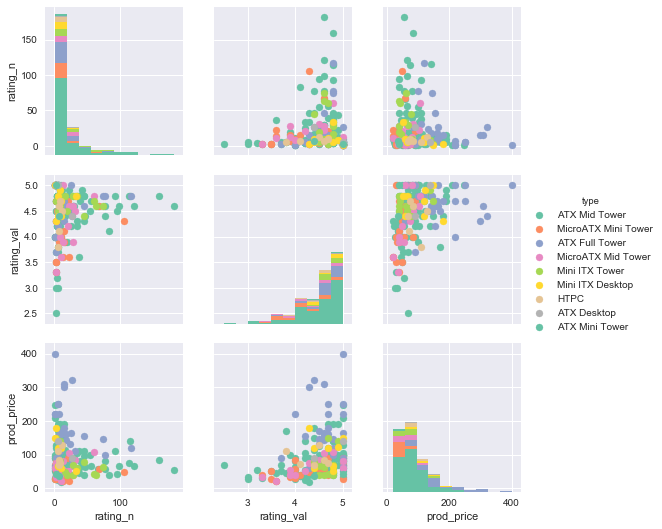

In [197]:
g = sns.PairGrid(case[['rating_n', 'rating_val', 'prod_price', 'type']], hue='type', palette='Set2')
g.map_diag(plt.hist, bins=10)
g.map_offdiag(plt.scatter)
g.add_legend()

## 2. Making case-motherboard compatibility extractable

### There are only 5 motherboard form factors we need to worry about:

In [198]:
list(motherboard['form factor'].unique())

['ATX', 'Micro ATX', 'Mini ITX', 'EATX', 'SSI EEB']

In [199]:
print case['motherboard compatibility'].describe()

count                        212
unique                        21
top       ATX-Micro ATX-Mini ITX
freq                          91
Name: motherboard compatibility, dtype: object


### Add a boolean column to the case dataframe indicating compatibility for each of the 5 mobos

In [200]:
mbus = list(motherboard['form factor'].unique())
for mbu in mbus:
    case['{} compatibility'.format(mbu)] = case['motherboard compatibility'].str.contains('{}'.format(mbu))
case.head(5)

,color,manufacturer,part #,type,model,motherboard compatibility,"internal 2.5"""" bays","internal 3.5"""" bays","external 5.25"""" bays","external 3.5"""" bays",...,rating_n,prod_name,prod_price,front panel usb 3.0 ports,dimensions,ATX compatibility,Micro ATX compatibility,Mini ITX compatibility,EATX compatibility,SSI EEB compatibility
1,Black/Red,NZXT,CA-S340W-BR1,ATX Mid Tower,S340 (Black/Red),ATX-Micro ATX-Mini ITX,2.0,3.0,0.0,0.0,...,56,NZXT S340 (Black/Red) ATX Mid Tower Case,64.98,Yes,,True,True,True,False,False
2,Black,Azza,CSAZ-206S,ATX Mid Tower,SIRIUS,ATX-Micro ATX,0.0,3.0,3.0,0.0,...,10,Azza SIRIUS ATX Mid Tower Case,19.98,No,"16.97"" x 7.87"" x 17.48""",True,True,False,False,False
3,Black/Blue,Deepcool,TESSERACT SW,ATX Mid Tower,0,ATX-Micro ATX-Mini ITX,0.0,4.0,2.0,0.0,...,46,Deepcool TESSERACT SW ATX Mid Tower Case,39.98,Yes,"16.93"" x 7.64"" x 17.17""",True,True,True,False,False
4,White,NZXT,CA-S340W-W1,ATX Mid Tower,S340 (White),ATX-Micro ATX-Mini ITX,2.0,3.0,0.0,0.0,...,121,NZXT S340 (White) ATX Mid Tower Case,64.98,Yes,,True,True,True,False,False
5,Black,Corsair,200R,ATX Mid Tower,0,ATX-Micro ATX-Mini ITX,4.0,4.0,3.0,0.0,...,182,Corsair 200R ATX Mid Tower Case,54.98,Yes,"19.57"" x 8.27"" x 16.89""",True,True,True,False,False


## 3. Convert ragged GPU size limits into inches (numeric)

In [201]:
#size_to_num defined in first few lines of document
    
case['gpu limit in'] = size_to_num(case, 'maximum video card length')

In [202]:
case.head(1)

,color,manufacturer,part #,type,model,motherboard compatibility,"internal 2.5"""" bays","internal 3.5"""" bays","external 5.25"""" bays","external 3.5"""" bays",...,prod_name,prod_price,front panel usb 3.0 ports,dimensions,ATX compatibility,Micro ATX compatibility,Mini ITX compatibility,EATX compatibility,SSI EEB compatibility,gpu limit in
1,Black/Red,NZXT,CA-S340W-BR1,ATX Mid Tower,S340 (Black/Red),ATX-Micro ATX-Mini ITX,2.0,3.0,0.0,0.0,...,NZXT S340 (Black/Red) ATX Mid Tower Case,64.98,Yes,,True,True,True,False,False,13.15


## 4. Color filtering for case

In [203]:
#This doesn't require more work, can use simple filters as below
case[case['color'].str.contains('Green')]

,color,manufacturer,part #,type,model,motherboard compatibility,"internal 2.5"""" bays","internal 3.5"""" bays","external 5.25"""" bays","external 3.5"""" bays",...,prod_name,prod_price,front panel usb 3.0 ports,dimensions,ATX compatibility,Micro ATX compatibility,Mini ITX compatibility,EATX compatibility,SSI EEB compatibility,gpu limit in
67,Black/Green,NZXT,CA-S340W-RA,ATX Mid Tower,S340 - Designed by Razer,ATX-Micro ATX-Mini ITX,2.0,3.0,0.0,0.0,...,NZXT S340 - Designed by Razer ATX Mid Tower Case,89.98,Yes,"17.01"" x 7.87"" x 17.52""",True,True,True,False,False,13.15
155,Black/Green,NZXT,CA-H440W-RA,ATX Mid Tower,H440 Designed by Razer,ATX-Micro ATX-Mini ITX,11.0,8.0,0.0,0.0,...,NZXT H440 Designed by Razer ATX Mid Tower Case,149.98,Yes,"22.05"" x 11.18"" x 21.89""",True,True,True,False,False,11.57
162,Green,Corsair,C70 Military Green,ATX Mid Tower,C70 Military Green (Green),ATX-EATX-Micro ATX-Mini ITX,0.0,6.0,3.0,0.0,...,Corsair C70 Military Green (Green) ATX Mid Tow...,109.98,Yes,"19.69"" x 9.09"" x 20.94""",True,True,True,True,False,12.60
190,Black/Green,DIYPC,Cuboid-G,MicroATX Mini Tower,0,Micro ATX-Mini ITX,2.0,3.0,1.0,0.0,...,DIYPC Cuboid-G MicroATX Mini Tower Case,49.98,Yes,,True,True,True,False,False,13.39


In [204]:
#Front panel usb is already well formed
case['front panel usb 3.0 ports'].unique()

array(['Yes', 'No'], dtype=object)

In [205]:
#Strip out leading space from column names:
case.columns = [re.sub('^\s','', col_name) for col_name in case.columns]
#Strip out "" symbols from inches columns
case.columns = [re.sub('\"\"', 'in', col_name) for col_name in case.columns]
print case.columns

Index([u'color', u'manufacturer', u'part #', u'type', u'model',
       u'motherboard compatibility', u'internal 2.5in bays',
       u'internal 3.5in bays', u'external 5.25in bays', u'external 3.5in bays',
       u'includes power supply', u'maximum video card length', u'prod_type',
       u'rating_val', u'rating_n', u'prod_name', u'prod_price',
       u'front panel usb 3.0 ports', u'dimensions', u'ATX compatibility',
       u'Micro ATX compatibility', u'Mini ITX compatibility',
       u'EATX compatibility', u'SSI EEB compatibility', u'gpu limit in'],
      dtype='object')


## 5. Numerical column correlation heatmap: CASE

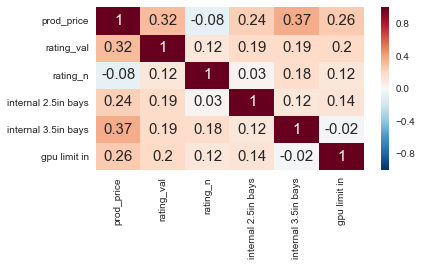

In [480]:
plt.figure(figsize=(6, 3))
sns.heatmap(case[['prod_price', 'rating_val', 'rating_n',
                         'internal 2.5in bays', 'internal 3.5in bays',
                         'gpu limit in']].corr().round(2), annot=True, annot_kws={"size": 15})

# CPU datatable cleaning and organizing

## 1. CPU specs with respect to rating and price

In [206]:
cpu.columns

Index([u'manufacturer', u'part #', u'model', u'data width', u'socket',
       u'operating frequency', u'max turbo frequency', u'cores', u'l1 cache',
       u'l2 cache', u'l3 cache', u'lithography', u'thermal design power',
       u'includes cpu cooler', u'hyper-threading', u'maximum supported memory',
       u'integrated graphics', u'prod_type', u'rating_val', u'rating_n',
       u'prod_name', u'prod_price', u'l2 cache-2'],
      dtype='object')

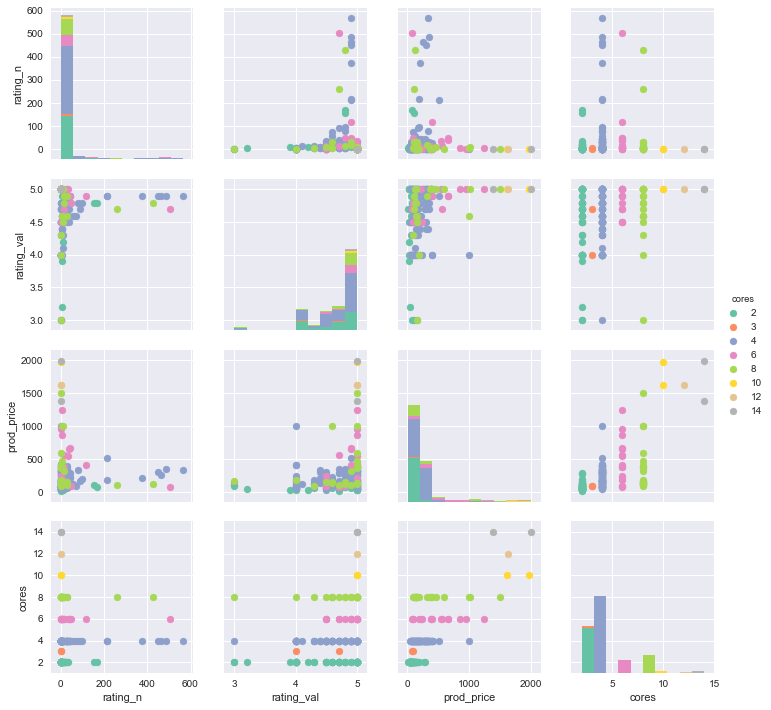

In [207]:
g = sns.PairGrid(cpu[['rating_n', 'rating_val', 'prod_price', 'cores']], hue='cores', palette='Set2')
g.map_diag(plt.hist, bins=10)
g.map_offdiag(plt.scatter)
g.add_legend()

## 2. Clean lithography node (in nm) to numeric to make it plottable

In [208]:
litho = [int(re.search('[0-9]{1,2}', cpu['lithography'][x]).group(0)) for x in range(1, cpu.shape[0]+1)]

cpu['lithography'] = litho
cpu[['lithography','prod_name','prod_price']].head()

,lithography,prod_name,prod_price
1,14,Intel Core i7-7700K 4.2GHz Quad-Core Processor,338.33
2,14,Intel Core i5-7600K 3.8GHz Quad-Core Processor,228.88
3,14,Intel Core i5-7500 3.4GHz Quad-Core Processor,188.88
4,14,AMD Ryzen 5 1600 3.2GHz 6-Core Processor,217.54
5,14,Intel Pentium G4560 3.5GHz Dual-Core Processor,59.47


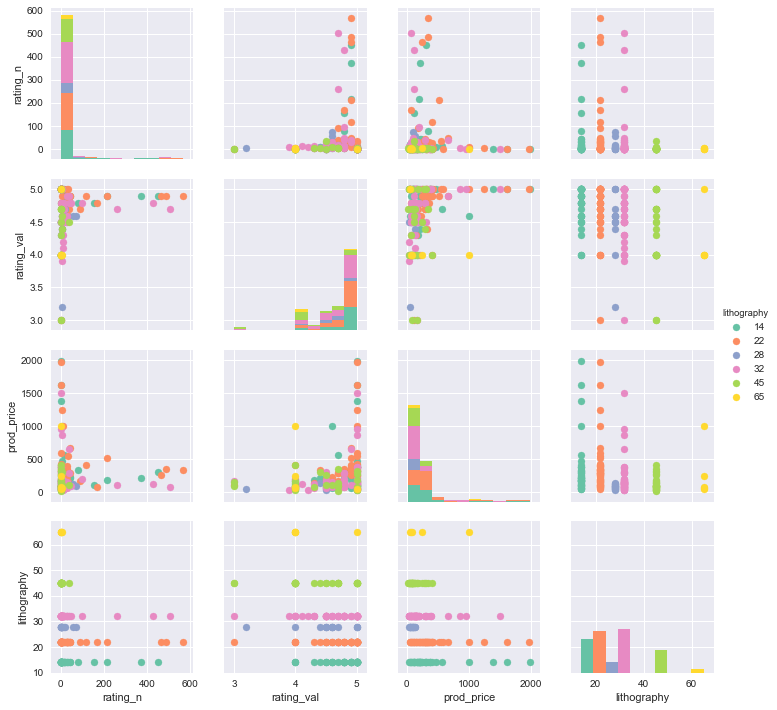

In [209]:
g = sns.PairGrid(cpu[['rating_n', 'rating_val', 'prod_price', 'lithography']], hue='lithography', palette='Set2')
g.map_diag(plt.hist, bins=10)
g.map_offdiag(plt.scatter)
g.add_legend()

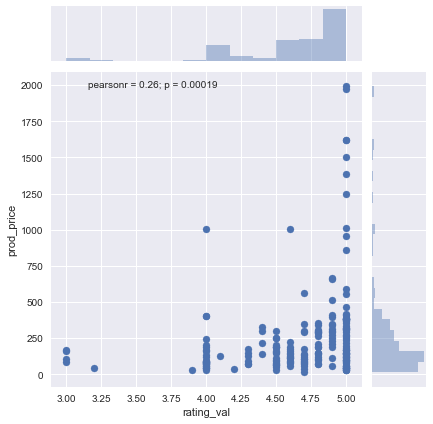

In [210]:
sns.jointplot(cpu['rating_val'], cpu['prod_price'])

## 3. Determine restrictive/interesting values for PC building

In [211]:
for el in ['socket', 'l1 cache', 'l2 cache', 'l2 cache-2', 'l3 cache', 'includes cpu cooler']:
    print '{} unique values: {}'.format(el, cpu[el].unique())

socket unique values: ['LGA1151' 'AM4' 'AM3+' 'LGA2011-3' 'FM2+' 'LGA1150' 'LGA775' 'LGA1155'
 'FM2' 'AM3/AM2+' 'LGA2011' 'AM1' 'LGA1156' 'LGA1366' 'AM3']
l1 cache unique values: ['4 x 32KB Instruction' '6 x 64KB Instruction' '2 x 32KB Instruction'
 '4 x 64KB Instruction' '8 x 64KB Instruction' '3 x 64KB Instruction'
 '6 x 32KB Instruction' '10 x 32KB Instruction' '2 x 96KB Instruction'
 '8 x 32KB Instruction' '2 x 64KB Instruction' '1 x 64KB Instruction'
 '1 x 96KB Instruction' '14 x 32KB Instruction' '12 x 32KB Instruction'
 '6 x 16KB Instruction' '8 x 16KB Instruction']
l2 cache unique values: ['4 x 256KB' '6 x 512KB' '2 x 256KB' '4 x 512KB' '8 x 512KB' '4 x 2MB'
 '3 x 2MB' '6 x 256KB' '10 x 256KB' '2 x 2MB' '1 x 6MB' '8 x 256KB'
 '1 x 1MB' '2 x 512KB' '2 x 4MB' '14 x 256KB' '12 x 256KB' '2 x 6MB'
 '1 x 3MB' '6 x 1MB' '1 x 4MB' '2 x 1MB' '8 x 1MB' '1 x 2MB' '3 x 512KB'
 '2 x 3MB']
l2 cache-2 unique values: [' 4 x 32KB' ' 6 x 32KB' ' 2 x 32KB' ' 8 x 32KB' ' 8 x 16KB' ' 6 x 16KB'
 ' 0

### Work with the L1 L2 L3 data to form numeric columns

In [212]:
###   First work with L1 data   ###
#Grab all of the L1 data out of the L1 column
l1 = [re.search('([0-9]{1,2}) x ([0-9]{1,2})([A-Za-z]{1,2})', cpu['l1 cache'][x]) for x in range(1, cpu.shape[0]+1)]

#Get the multiplier out of the L1 data
l1_mult = [int(l1[x].group(1)) for x in range(0, cpu.shape[0])]
#Likewise for the data-size value
l1_val = [int(l1[x].group(2)) for x in range(0, cpu.shape[0])]
#And finally the data type
l1_type = [str(l1[x].group(3)) for x in range(0, cpu.shape[0])]

for i in range(0, cpu.shape[0]):
    if str(l1[i].group(3)) != 'KB':
        print 'Not L1 in KB'

#All values for L1 are in KB, can multiply both L1 values together without data type problems
cpu['l1 total'] = [x[0]*x[1] for x in zip(l1_mult, l1_val)]
cpu.head(1)

,manufacturer,part #,model,data width,socket,operating frequency,max turbo frequency,cores,l1 cache,l2 cache,...,hyper-threading,maximum supported memory,integrated graphics,prod_type,rating_val,rating_n,prod_name,prod_price,l2 cache-2,l1 total
1,Intel,BX80677I77700K,0,64-bit,LGA1151,4.2GHz,4.5GHz,4,4 x 32KB Instruction,4 x 256KB,...,Yes,64GB,Intel HD Graphics 630,CPU,4.8,80,Intel Core i7-7700K 4.2GHz Quad-Core Processor,338.33,4 x 32KB,128


In [213]:
###   Now work with L2 data   ###
#Grab all of the L2 data out of the L2 column
l2 = [re.search('([0-9]{1,2}) x ([0-9]{1,3})([A-Za-z]{1,2})', cpu['l2 cache'][x]) for x in range(1, cpu.shape[0]+1)]

#Get the multiplier out of the L1 data
l2_mult = [int(l2[x].group(1)) for x in range(0, cpu.shape[0])]
#Likewise for the data-size value
l2_val = [int(l2[x].group(2)) for x in range(0, cpu.shape[0])]
#And finally the data type
l2_type = [str(l2[x].group(3)) for x in range(0, cpu.shape[0])]

#Convert MB to KB
l2_val = [int(l2[x].group(2)) if str(l2[x].group(3)) == 'KB' else int(l2[x].group(2))*2**10 for x in range(0, cpu.shape[0])]

#Assign values to dataframe
cpu['l2 total'] = [x[0]*x[1] for x in zip(l2_mult, l2_val)]
cpu.head(1)

,manufacturer,part #,model,data width,socket,operating frequency,max turbo frequency,cores,l1 cache,l2 cache,...,maximum supported memory,integrated graphics,prod_type,rating_val,rating_n,prod_name,prod_price,l2 cache-2,l1 total,l2 total
1,Intel,BX80677I77700K,0,64-bit,LGA1151,4.2GHz,4.5GHz,4,4 x 32KB Instruction,4 x 256KB,...,64GB,Intel HD Graphics 630,CPU,4.8,80,Intel Core i7-7700K 4.2GHz Quad-Core Processor,338.33,4 x 32KB,128,1024


In [214]:
###   Next work with L2-2 data   ###
#Grab all of the L2-2 data out of the L2-2 column
l2_2 = [re.search('([0-9]{1,2}) x ([0-9]{1,3})([A-Za-z]{1,2})', cpu['l2 cache-2'][x]) for x in range(1, cpu.shape[0]+1)]

#Get the multiplier out of the L1 data
l2_2_mult = [int(l2_2[x].group(1)) for x in range(0, cpu.shape[0])]
#Likewise for the data-size value
l2_2_val = [int(l2_2[x].group(2)) for x in range(0, cpu.shape[0])]
#And finally the data type
l2_2_type = [str(l2_2[x].group(3)) for x in range(0, cpu.shape[0])]

#Convert MB to KB
l2_2_val = [int(l2_2[x].group(2)) if str(l2_2[x].group(3)) == 'KB' else int(l2_2[x].group(2))*2**10 for x in range(0, cpu.shape[0])]

#Assign values to dataframe
cpu['l2-2 total'] = [x[0]*x[1] for x in zip(l2_2_mult, l2_2_val)]
cpu[['l2 cache-2', 'l2-2 total']].head()

,l2 cache-2,l2-2 total
1,4 x 32KB,128
2,4 x 32KB,128
3,4 x 32KB,128
4,6 x 32KB,192
5,2 x 32KB,64


In [215]:
###   Finally work with L2-2 data   ###
#Grab all of the L3 data out of the L3 column
l3 = [re.search('([0-9]{1,2}) x ([0-9]{1,2})([A-Za-z]{1,2})', cpu['l3 cache'][x]) for x in range(1, cpu.shape[0]+1)]

l3_mult = []
l3_val = []
    
for x in range(0, cpu.shape[0]):
    #Get the multiplier out of the L3 data
    try:
        l3_mult.append(int(l3[x].group(1)))
    except:
        l3_mult.append(0)

    #Likewise for the data-size value
    try:
        l3_val.append(int(l3[x].group(2)))
    except: 
        l3_val.append(0)

#All values for L3 are in MB, can multiply both L3 values together without data type problems
cpu['l3 total'] = [x[0]*x[1] for x in zip(l3_mult, l3_val)]
cpu[['l3 cache', 'l3 total']].tail()

,l3 cache,l3 total
199,1 x 3MB,3
200,1 x 35MB,35
201,1 x 6MB,6
202,1 x 2MB,2
203,None,0


### Clean up the socket column

In [216]:
#Get all unique values
sockets = list(cpu['socket'].unique())
print sockets

['LGA1151', 'AM4', 'AM3+', 'LGA2011-3', 'FM2+', 'LGA1150', 'LGA775', 'LGA1155', 'FM2', 'AM3/AM2+', 'LGA2011', 'AM1', 'LGA1156', 'LGA1366', 'AM3']


In [217]:
#Most of the entries are fine, need to clean up 'AM3/AM2+'
clean_socket = []
for el in cpu['socket']:
    try:
        re.search('(AM3/AM2\+)', el).group(0)
        clean_socket.append('AM2+-AM3')
    except:
        clean_socket.append(el)
cpu['socket'] = clean_socket

### Convert thermal design power to numeric

In [218]:
cpu['tdp'] = [re.search('([0-9]{2,3})', x).group(1) for x in cpu['thermal design power']]

In [219]:
cpu['op freq n'] = [float(re.search('([0-9]\.[0-9])', x).group(1)) for x in cpu['operating frequency']]

max_turbo_list = []
for x in cpu['max turbo frequency']:
    try:
        max_turbo_list.append(float(re.search('([0-9]\.[0-9])', x).group(1)))
    except:
        max_turbo_list.append(float(0))
        
cpu['turbo freq n'] = max_turbo_list

cpu[['op freq n', 'turbo freq n']][1:5]

,op freq n,turbo freq n
2,3.8,4.2
3,3.4,3.8
4,3.2,3.6
5,3.5,0.0


## 4. Numerical column correlation heatmap: CPU

In [360]:
cpu_n = cpu[cpu['prod_price'] < np.mean(cpu['prod_price']) + 2*np.std(cpu['prod_price'])]

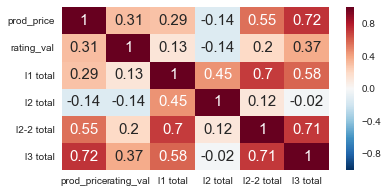

In [481]:
plt.figure(figsize=(6, 3))
sns.heatmap(cpu_n[['prod_price', 'rating_val',
                 'l1 total', 'l2 total', 'l2-2 total', 'l3 total'
                ]].corr().round(2), annot=True, annot_kws={"size": 15})

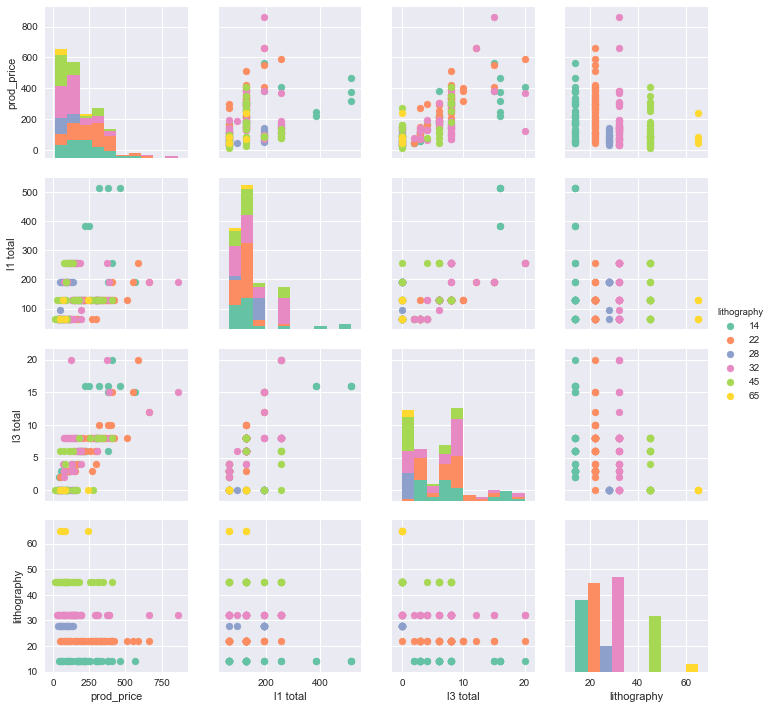

In [369]:
g = sns.PairGrid(cpu_n[['prod_price', 'l1 total', 'l3 total', 'lithography']], hue='lithography', palette='Set2')
g.map_diag(plt.hist, bins=10)
g.map_offdiag(plt.scatter)
g.add_legend()

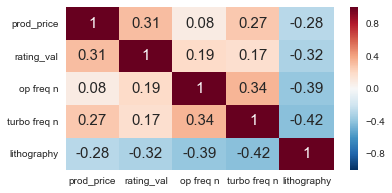

In [482]:
plt.figure(figsize=(6, 3))
sns.heatmap(cpu_n[['prod_price', 'rating_val',
                 'op freq n', 'turbo freq n',
                 'lithography'
                ]].corr().round(2), annot=True, annot_kws={"size": 15})

# Cooler dataframe cleaning and organizing

## 1. Cooler specs with respect to rating and price

In [220]:
cooler.columns

Index([u'manufacturer', u'part #', u'model', u'height', u'prod_type',
       u'rating_val', u'rating_n', u'prod_name', u'prod_price',
       u'radiator size', u'noise level', u'supported sockets', u'fan rpm',
       u'liquid cooled'],
      dtype='object')

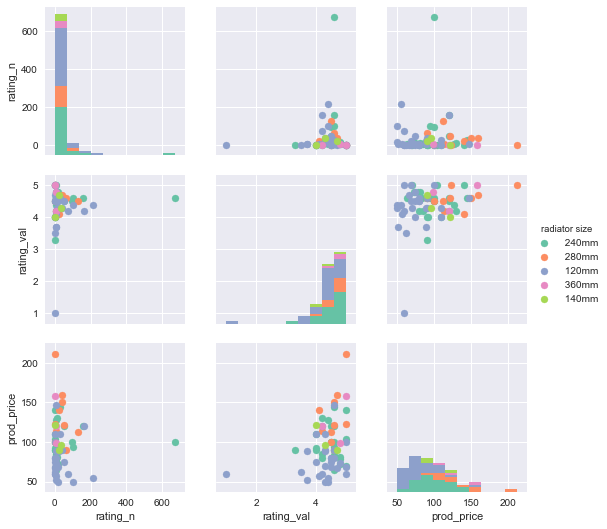

In [221]:
cooler_filter = cooler[['rating_n', 'rating_val', 'prod_price', 'radiator size']][cooler['radiator size'] != ' ']
g = sns.PairGrid(cooler_filter, hue='radiator size', palette='Set2')
g.map_diag(plt.hist, bins=10, normed=False)
g.map_offdiag(plt.scatter)
g.add_legend()

## 2. Convert ragged height and size specs into numeric values

In [222]:
#Take a look at the height column first
cooler_limit=[]
for i in range(1, cooler.shape[0]+1):
    if type(cooler['height'][i])==int:
        cooler_limit.append(0.0)
    else:
        cooler_limit.append(float(re.search('[0-9]{1,2}\.[0-9]+', cooler['height'][i]).group(0)))

cooler['numeric height'] = cooler_limit

In [223]:
#Apply same correction to radiator size column
cooler_limit=[]
for i in range(1, cooler.shape[0]+1):
    if cooler['radiator size'][i]==' ':
        cooler_limit.append(0)
    else:
        cooler_limit.append(int(re.search('[0-9]{1,3}', cooler['radiator size'][i]).group(0)))

cooler['numeric size'] = cooler_limit
print cooler['numeric size'].unique()

[  0 240 280 120 360 140]


## 3. Convert potential values of interest to useable form

### Start with liquid cooled: convert to boolean

In [224]:
print cooler['liquid cooled'].head()
cooler['liquid cooled'] = [True if x == ' Yes' else False for x in cooler['liquid cooled']]
print cooler['liquid cooled'].head()

1      No
2     Yes
3     Yes
4      No
5     Yes
Name: liquid cooled, dtype: object
1    False
2     True
3     True
4    False
5     True
Name: liquid cooled, dtype: bool


### Now analyze noise level information

In [225]:
print cooler['noise level'].head()
print '\n'

#Limit finder return a list of lists: first list is min
cooler['noise level min'] = limit_finder(cooler,'noise level', float, 3)[0]
#Second list is max noise level (or nominal if min is missing)
cooler['noise level max'] = limit_finder(cooler,'noise level', float, 3)[1]

print cooler[['noise level', 'noise level min', 'noise level max']].head()

1      9.0 - 36.0 dbA
2            37.7 dbA
3     21.0 - 38.0 dbA
4      1.0 - 25.0 dbA
5            30.9 dbA
Name: noise level, dtype: object


        noise level  noise level min  noise level max
1    9.0 - 36.0 dbA              9.0             36.0
2          37.7 dbA              0.0             37.7
3   21.0 - 38.0 dbA             21.0             38.0
4    1.0 - 25.0 dbA              1.0             25.0
5          30.9 dbA              0.0             30.9


### Next look at RPM information

In [226]:
#Has same format as noise level information
print cooler['fan rpm'].head()
print '\n'

#Limit finder return a list of lists: first list is min
cooler['fan rpm min'] = limit_finder(cooler,'fan rpm', int, 3)[0]
#Second list is max noise level (or nominal if min is missing)
cooler['fan rpm max'] = limit_finder(cooler,'fan rpm', int, 3)[1]

print cooler[['fan rpm', 'fan rpm min', 'fan rpm max']].head()

1     600 - 2000 RPM
2           2435 RPM
3     500 - 1800 RPM
4     330 - 1600 RPM
5           2000 RPM
Name: fan rpm, dtype: object


           fan rpm  fan rpm min  fan rpm max
1   600 - 2000 RPM          600         2000
2         2435 RPM            0         2435
3   500 - 1800 RPM          500         1800
4   330 - 1600 RPM          330         1600
5         2000 RPM            0         2000


### Convert compatible socket information to boolean columns for convenience

In [227]:
sockets = list(cpu['socket'].unique())
print 'unique sockets from cpu list:\n {} \n'.format(sockets)

def cooler_tests(df, column_str, specific_arg, general_arg):
    if len(df[column_str][~(df[column_str].str.contains(specific_arg)) &
                                       (df[column_str].str.contains(general_arg))]) == 0:
        return 'If {} is supported, {} is also supported \n'.format(general_arg, specific_arg)
    
    else:
        return 'Need to separate {} & {}\n'.format(general_arg, specific_arg)


unique sockets from cpu list:
 ['LGA1151', 'AM4', 'AM3+', 'LGA2011-3', 'FM2+', 'LGA1150', 'LGA775', 'LGA1155', 'FM2', 'AM2+-AM3', 'LGA2011', 'AM1', 'LGA1156', 'LGA1366', 'AM3'] 



In [228]:
for el in [['LGA2011-3', 'LGA2011'],
           ['FM2+', 'FM2'],
           ['AM3+', 'AM2'],
           ['AM4', 'AM3']]:
    print cooler_tests(cooler, 'supported sockets', el[0], el[1])
#Lets generalize this to figure out what our minimum number of values is

If LGA2011 is supported, LGA2011-3 is also supported 

If FM2 is supported, FM2+ is also supported 

If AM2 is supported, AM3+ is also supported 

Need to separate AM3 & AM4



In [229]:
def cooler_tests_v2(df, column_str, df2, column_str2, general_arg):
    return_list = []
    for el in df2[column_str2].unique():
        if len(df[column_str][~(df[column_str].str.contains(el)) &
                                           (df[column_str].str.contains(general_arg))]) == 0:
            return_list.append('If {} is supported, {} is also supported \n'.format(general_arg, el))
            if len(df[column_str][~(df[column_str].str.contains(general_arg)) &
                                               (df[column_str].str.contains(el))]) == 0:
                return_list.append('If {} is supported, {} is also supported \n'.format(el, general_arg))
            else: return_list.append('Need to separate {} & {}\n'.format(el, general_arg))
        else:
            return_list.append('Need to separate {} & {}\n'.format(general_arg, el))
            if len(df[column_str][~(df[column_str].str.contains(general_arg)) &
                                               (df[column_str].str.contains(el))]) == 0:
                return_list.append('If {} is supported, {} is also supported \n'.format(el, general_arg))
            else:
                return_list.append('Need to separate {} & {}\n'.format(el, general_arg))
    return return_list

In [230]:
#for el in list(cpu['socket'].unique()):
    #for x in cooler_tests_v2(cooler, 'supported sockets', cpu, 'socket', 'AM1'):
        #print x
        
#AM1, AM4, LGA775, LGA1366 have no equal
#LGA1151, LGA1150, LGA1155, LGA1156 are interchangeable
#AM3, AM3+, FM2+, FM2 are interchangeable
#LGA2011, LGA2011-3 are interchangeable
#If AM2+-AM3 is supported, everything is supported

unique_sockets = ['AM1', 'AM4', 'LGA775', 'LGA1366', 'AM2', 'AM3', 'LGA1151', 'LGA2011']
print unique_sockets

['AM1', 'AM4', 'LGA775', 'LGA1366', 'AM2', 'AM3', 'LGA1151', 'LGA2011']


### Key result: can now grab compatible coolers from cpu filtering

In [231]:
def socket_filter(socket):
    return [True if re.search(socket, x) else False for x in cooler['supported sockets']]

print '{} socket for chosen CPU'.format(cpu['socket'][203])
print '\n'
print 'compatible sockets for chosen cooler: \n{}'.format(cooler['supported sockets'][socket_filter(cpu['socket'][203])][1])

LGA775 socket for chosen CPU


compatible sockets for chosen cooler: 
 AM2-AM2+-AM3-AM3+-AM4-FM1-FM2-FM2+-LGA1150-LGA1151-LGA1155-LGA1156-LGA1366-LGA2011-LGA2011-3-LGA775


In [232]:
cooler.head(1)

,manufacturer,part #,model,height,prod_type,rating_val,rating_n,prod_name,prod_price,radiator size,noise level,supported sockets,fan rpm,liquid cooled,numeric height,numeric size,noise level min,noise level max,fan rpm min,fan rpm max
1,Cooler Master,RR-212E-20PK-R2,Hyper 212 EVO,"6.26"""" (159mm)",CPU Cooler,4.6,1234,Cooler Master Hyper 212 EVO 82.9 CFM Sleeve Be...,24.87,,9.0 - 36.0 dbA,AM2-AM2+-AM3-AM3+-AM4-FM1-FM2-FM2+-LGA1150-LG...,600 - 2000 RPM,False,6.26,0,9.0,36.0,600,2000


## 4. Numerical column correlation heatmap: Cooler

In [379]:
cooler_n = cooler[cooler['prod_price'] < np.mean(cooler['prod_price']) + 2*np.std(cooler['prod_price'])]
cooler_n = cooler[cooler['prod_price'] > 0]

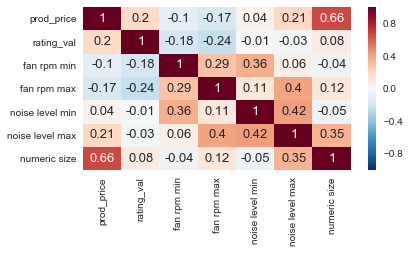

In [485]:
plt.figure(figsize=(6, 3))
sns.heatmap(cooler_n[['prod_price', 'rating_val',
                      'fan rpm min', 'fan rpm max',
                      'noise level min', 'noise level max',
                      'numeric size'
                ]].corr().round(2), annot=True, annot_kws={"size": 13})

# GPU dataframe cleaning and organizing

## 1. GPU specs with respect to rating and price

In [233]:
print gpu.columns

Index([u'manufacturer', u'part #', u'model', u'interface', u'chipset',
       u'sli support', u'memory size', u'memory type', u'crossfire support',
       u'core clock', u'boost clock', u'dvi-d dual-link', u'dvi-i dual-link',
       u'hdmi', u'mini-hdmi', u'displayport', u'length', u'tdp',
       u'supports g-sync', u'prod_type', u'rating_val', u'rating_n',
       u'prod_name', u'prod_price'],
      dtype='object')


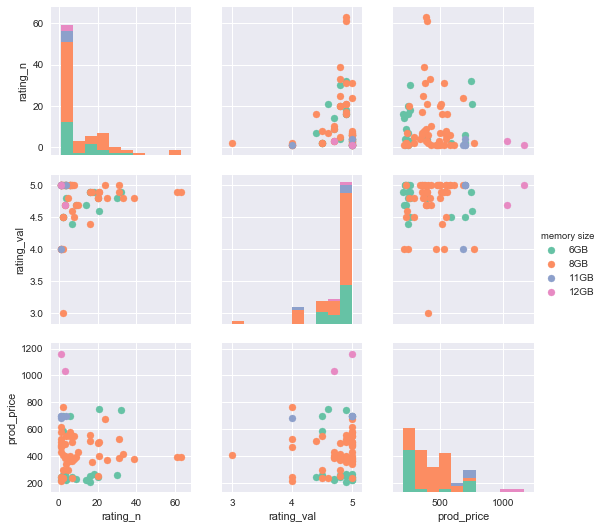

In [234]:
gpu_filter = gpu[gpu['memory size'].isin(['12GB', '11GB', '8GB', '6GB'])]
g = sns.PairGrid(gpu_filter[['rating_n', 'rating_val', 'prod_price', 'memory size']], hue='memory size', palette='Set2')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

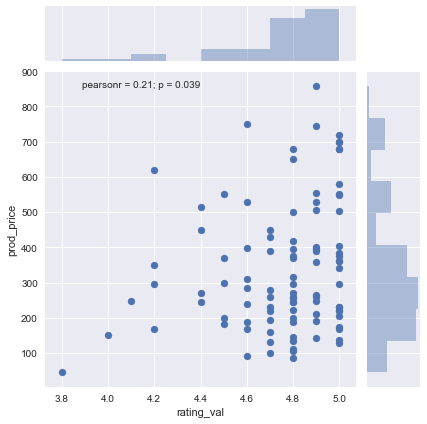

In [235]:
gpu_filter = gpu[gpu['rating_n'] > 3]
sns.jointplot(gpu_filter['rating_val'], gpu_filter['prod_price'])

/Users/samo/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/samo/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


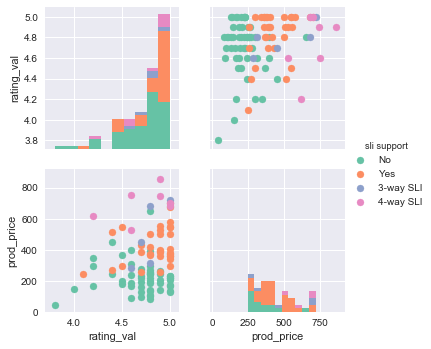

In [236]:
gpu_filter = gpu[gpu['rating_n'] > 3]
g = sns.PairGrid(gpu_filter[['rating_val', 'prod_price', 'sli support', 'crossfire support']], hue='sli support', palette='Set2')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

## 2. Determine interesting/restrictive values for GPUs

In [237]:
for el in ['tdp', 'memory type', 'sli support', 'crossfire support', 'supports g-sync']:
    print '{} unique values: {}'.format(el, gpu[el].unique())

tdp unique values: ['120 Watts' '75 Watts' '150 Watts' '170 Watts' '180 Watts' '250 Watts'
 '215 Watts' '60 Watts' '225 Watts' '270 Watts' '145 Watts' '230 Watts'
 '30 Watts' '19 Watts' '29 Watts' '165 Watts' '55 Watts' '190 Watts'
 '90 Watts' '100 Watts' '65 Watts' '175 Watts' '142 Watts' '110 Watts'
 '27 Watts' '300 Watts' '140 Watts' '275 Watts' '20 Watts' '66 Watts'
 '195 Watts' '200 Watts' '15 Watts' '49 Watts' '130 Watts' '210 Watts']
memory type unique values: ['GDDR5' 'GDDR5X' 'DDR3' 'HBM' 'DDR2' 'DDR5']
sli support unique values: ['No' 'Yes' '4-way SLI' '3-way SLI']
crossfire support unique values: ['No' 'Yes' '4-way CrossFire']
supports g-sync unique values: ['Yes' 0]


In [238]:
#Need to rescrape html for 'supports freesync' if we want to use g-sync info

## 3. Cleaning values into proper numeric form where necessary

In [239]:
#TDP is related to energy used under load
tdp_vals = [int(re.search('([0-9]{2,3})', gpu['tdp'][x]).group(1)) for x in range(1, gpu.shape[0]+1)]
gpu['tdp'] = tdp_vals

In [240]:
#Length is in inches, need to strip out unnecessary parts
gpu['length'] = size_to_num(gpu, 'length')

In [241]:
#Convert from text to number of gpus allowed (sli or crossfire) and store the max of the two numbers
gpu['max gpus'] = map(lambda x: max([x[0],x[1]]),
                      zip(sli_cross_num(gpu, 'sli support'),
                          sli_cross_num(gpu, 'crossfire support')))

In [242]:
gpu['interface'].unique()

array(['PCI-Express x16'], dtype=object)

In [243]:
gpu['memory size'].unique()

array(['6GB', '4GB', '8GB', '11GB', '2GB', '3GB', '12GB', '1GB', '512MB',
       '768MB'], dtype=object)

In [244]:
print 'Unique values of "memory size" column:\n{}\n'.format(gpu['memory size'].unique())

#Look for GB and MB identifier, store the number value in the first group; store the unit in the second/third group
gpu_mem = [re.search('([0-9]+)(MB)?(GB)?', x) for x in gpu['memory size']]

#Multiply by the appropriate conversion
gpu['mem int'] = [float(x.group(1))/(2**10) if x.group(2)=='MB' else int(x.group(1)) for x in gpu_mem]

print 'Unique values of "mem int" column:\n{}\n'.format(gpu['mem int'].unique())

Unique values of "memory size" column:
['6GB' '4GB' '8GB' '11GB' '2GB' '3GB' '12GB' '1GB' '512MB' '768MB']

Unique values of "mem int" column:
[  6.     4.     8.    11.     2.     3.    12.     1.     0.5    0.75]



### Converting clock numbers to numeric

In [271]:
gpu['core clock'].unique()

array(['1.51GHz', '1.37GHz', '1.63GHz', '1.61GHz', '1.35GHz', '1.59GHz',
       '1.71GHz', '1.48GHz', '1.67GHz', '1.09GHz', '1.58GHz', '1.52GHz',
       '1.62GHz', '1.34GHz', '1.12GHz', '1.56GHz', '926MHz', '1.54GHz',
       '1.72GHz', '1.29GHz', '1.08GHz', '1.76GHz', '1.30GHz', '1.53GHz',
       '1.0GHz', '1.21GHz', '1.77GHz', '1.13GHz', '1.05GHz', '1.24GHz',
       '1.68GHz', '1.19GHz', '1.39GHz', '1.11GHz', '1.02GHz', '520MHz',
       '1.18GHz', '954MHz', '1.04GHz', '810MHz', '1.23GHz', '1.22GHz',
       '970MHz', '1.07GHz', '1.06GHz', '1.03GHz', '990MHz', '1.1GHz',
       '947MHz', '1.20GHz', '1.01GHz', '730MHz', '900MHz', '980MHz',
       '1.14GHz', '800MHz', '700MHz', '600MHz', '863MHz', '928MHz',
       '1.25GHz', '650MHz', '625MHz', '820MHz', '902MHz', '875MHz',
       '973MHz', '860MHz', '965MHz', '880MHz', '822MHz', '710MHz', '850MHz'], dtype=object)

In [269]:
#Look for GHz and MHz identifier, store the number value in the first group; store the unit in the second/third group
gpu_cc = [re.search('([0-9]+)(M)?(G)?Hz', x) for x in gpu['core clock']]

#Multiply by the appropriate conversion
gpu['core n'] = [float(x.group(1))/(2**10) if x.group(2)=='M' else 1+float(x.group(1))/100 for x in gpu_cc]

print 'First few values of "core n" column:\n{}\n'.format(gpu[['core clock', 'core n']][0:5])

First few values of "core n" column:
  core clock  core n
1    1.51GHz    1.51
2    1.37GHz    1.37
3    1.63GHz    1.63
4    1.61GHz    1.61
5    1.35GHz    1.35



/Users/samo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [272]:
gpu['boost clock'].unique()

array(['1.81GHz', '1.48GHz', '1.86GHz', '1.83GHz', '1.47GHz', '1.78GHz',
       '1.85GHz', '1.58GHz', '1.80GHz', '1.21GHz', '1.71GHz', '1.87GHz',
       '1.46GHz', '1.32GHz', '1.77GHz', '1.82GHz', '1.29GHz', '1.27GHz',
       '1.76GHz', '1.73GHz', '1.68GHz', '1.75GHz', '1.49GHz', '1.16GHz',
       '1.94GHz', '1.42GHz', '1.72GHz', '1.33GHz', '1.51GHz', '1.07GHz',
       '1.34GHz', '1.24GHz', '1.39GHz', '1.56GHz', '1.91GHz', '1.31GHz',
       '1.22GHz', '1.18GHz', '1.30GHz', 0, '1.43GHz', '1.25GHz', '1.08GHz',
       '1.28GHz', '1.2GHz', '1.38GHz', '1.0GHz', '1.05GHz', '1.14GHz',
       '1.23GHz', '1.15GHz', '1.37GHz', '955MHz', '1.1GHz', '1.35GHz',
       '928MHz', '925MHz'], dtype=object)

In [273]:
#Look for GHz and MHz identifier, store the number value in the first group; store the unit in the second/third group
gpu_bc = []

for boost in gpu['boost clock']:
    try:
        gpu_bc.append(1+float(re.search('([0-9]+)(M)?(G)?Hz', boost).group(1))/100)
    except:
        gpu_bc.append(float(0))

#Multiply by the appropriate conversion
gpu['boost n'] = gpu_bc

print 'First few values of "boost n" column:\n{}\n'.format(gpu[['boost n', 'boost clock']][0:5])

First few values of "boost n" column:
   boost n boost clock
1     1.81     1.81GHz
2     1.48     1.48GHz
3     1.86     1.86GHz
4     1.83     1.83GHz
5     1.47     1.47GHz



/Users/samo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [274]:
gpu[['length','tdp', 'max gpus', 'mem int', 'core n', 'boost n']].head()

,length,tdp,max gpus,mem int,core n,boost n
1,10.91,120,1,6.0,1.51,1.81
2,9.02,75,1,4.0,1.37,1.48
3,11.73,150,2,8.0,1.63,1.86
4,6.81,120,1,6.0,1.61,1.83
5,5.71,75,1,4.0,1.35,1.47


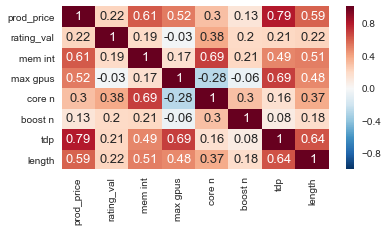

In [487]:
plt.figure(figsize=(6, 3))
sns.heatmap(gpu[['prod_price', 'rating_val',
                      'mem int', 'max gpus',
                      'core n', 'boost n',
                      'tdp', 'length'
                ]].corr().round(2), annot=True, annot_kws={"size": 13})

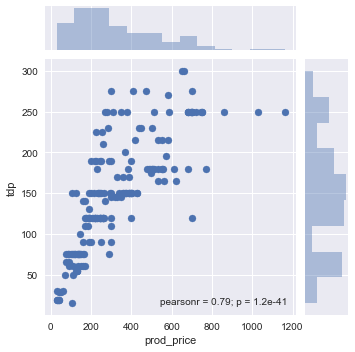

In [495]:
sns.jointplot(gpu['prod_price'], gpu['tdp'], size=5)

# Memory dataframe cleaning and organizing

## 1. Memory specs with respect to rating and price

In [275]:
print memory.columns

Index([u'color', u'manufacturer', u'part #', u'type', u'price/gb', u'speed',
       u'size', u'cas latency', u'voltage', u'heat spreader', u'ecc',
       u'registered', u'prod_type', u'rating_val', u'rating_n', u'prod_name',
       u'prod_price'],
      dtype='object')


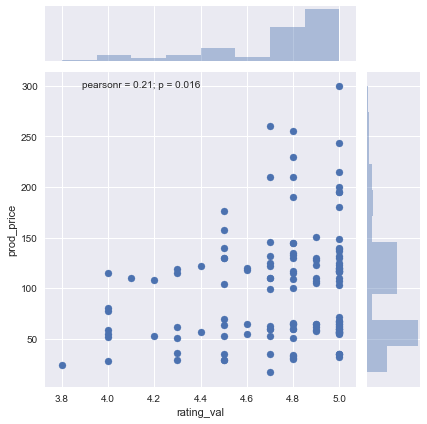

In [276]:
memory_filter = memory[memory['rating_n']>1]
g = sns.jointplot(memory_filter['rating_val'], memory_filter['prod_price'])

### Quick strip of dollar sign from price/gb column

In [277]:
memory['price/gb dollars'] = [float(re.search('\$([0-9]{1,4}\.[0-9]+)', x).group(1)) for x in memory['price/gb']]
print memory[['price/gb dollars', 'price/gb']].tail(2)


     price/gb dollars price/gb
199              7.25    $7.25
200              8.12    $8.12


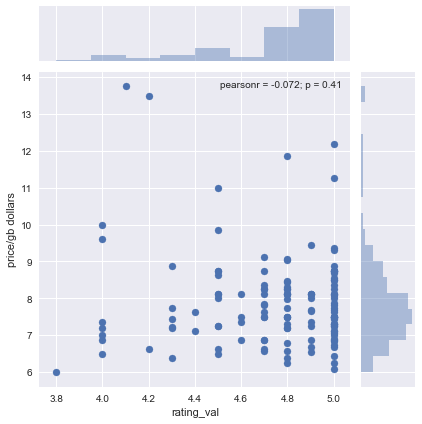

In [278]:
memory_filter = memory[memory['rating_n']>1]
g = sns.jointplot(memory_filter['rating_val'], memory_filter['price/gb dollars'])

## 2. Cleaning values for compatibility: memory

In [279]:
#Speed is already good for motherboard compatibility check
memory['speed'].unique()

array(['DDR3-1333', 'DDR3-2133', 'DDR3-1600', 'DDR4-2133', 'DDR4-2666',
       'DDR4-2400', 'DDR4-3200', 'DDR3-1866', 'DDR4-2800', 'DDR3-2400',
       'DDR2-667', 'DDR4-3000', 'DDR4-3333', 'DDR2-800', 'DDR3-2666'], dtype=object)

In [280]:
#For SQL use later, we need to convert to type and speed
memory['speed type'] = [int(re.search('DDR([0-9])', x).group(1)) for x in memory['speed']]
memory['speed n'] = [int(re.search('-([0-9]{3,4})', x).group(1)) for x in memory['speed']]
memory[['speed', 'speed type', 'speed n']][0:4]

,speed,speed type,speed n
1,DDR3-1333,3,1333
2,DDR3-2133,3,2133
3,DDR3-1600,3,1600
4,DDR4-2133,4,2133


### Motherboard only contains 240-pin DIMM and 288-pin DIMM: make numeric then filter

In [281]:
#Find unique values of memory type
print memory['type'].unique()

['240-pin DIMM' '288-pin DIMM' '260-pin SODIMM' '204-pin SODIMM']


In [282]:
#Create new column with numeric values of the type column for easy filtering
memory['mem type'] = [int(re.search('([0-9]{3,})', x).group(1)) for x in memory['type']]
print memory[['type', 'mem type']].head(3)

           type  mem type
1  240-pin DIMM       240
2  240-pin DIMM       240
3  240-pin DIMM       240


In [283]:
#Filter out columns that are not 240 or 288 pin
memory = memory[memory['mem type'].isin([240, 288])]
print memory['type'].unique()

['240-pin DIMM' '288-pin DIMM']


## 3. Convert size column to 2 columns: total size, number of sticks

In [284]:
memory['size'].unique()

array(['8GB (1 x 8GB)', '16GB (2 x 8GB)', '4GB (1 x 4GB)',
       '16GB (4 x 4GB)', '8GB (2 x 4GB)', '32GB (2 x 16GB)',
       '32GB (4 x 8GB)', '1GB (1 x 1GB)', '2GB (1 x 2GB)', '4GB (2 x 2GB)',
       '12GB (3 x 4GB)', '24GB (6 x 4GB)', '12GB (6 x 2GB)',
       '64GB (4 x 16GB)'], dtype=object)

In [285]:
### From above output, see that we need to grab the number before GB and the first number in parentheses ###

#First grab the leading number
memory['total mem'] = [int(re.search('^([0-9]+)', x).group(1)) for x in memory['size']]

#Then grab the multiplier
memory['num sticks'] = [int(re.search('\(([0-9])', x).group(1)) for x in memory['size']]

memory[['size', 'total mem', 'num sticks']].head()

,size,total mem,num sticks
1,8GB (1 x 8GB),8,1
2,16GB (2 x 8GB),16,2
3,16GB (2 x 8GB),16,2
4,4GB (1 x 4GB),4,1
5,16GB (4 x 4GB),16,4


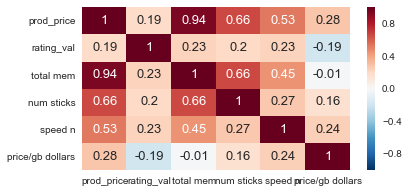

In [488]:
plt.figure(figsize=(6, 3))
sns.heatmap(memory[['prod_price', 'rating_val',
                 'total mem', 'num sticks',
                 'speed n', 'price/gb dollars'
                ]].corr().round(2), annot=True, annot_kws={"size": 13})

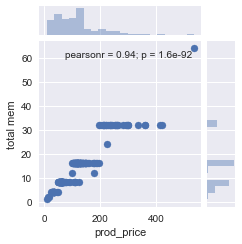

In [492]:
sns.jointplot(memory['prod_price'], memory['total mem'], size=3.5)

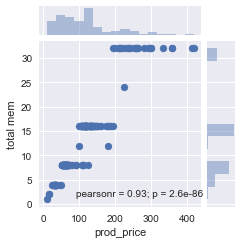

In [493]:
memory_filter = memory[memory['total mem'] < 60]
sns.jointplot(memory_filter['prod_price'], memory_filter['total mem'], size=3.5)

# Motherboard dataframe cleaning and organizing

## 1. Motherboard specs with respect to rating and price

In [286]:
print motherboard.columns

Index([u'manufacturer', u'part #', u'model', u'maximum supported memory',
       u'form factor', u'chipset', u'sli support', u'memory type',
       u'crossfire support', u'cpu socket', u'memory slots', u'raid support',
       u'sata 6 gb/s', u'sata express', u'onboard ethernet',
       u'onboard usb 3.0 header(s)', u'u.2', u'onboard video', u'prod_type',
       u'rating_val', u'rating_n', u'prod_name', u'prod_price'],
      dtype='object')


In [287]:
#Found out NaN price value that slipped through earlier filtering
motherboard = motherboard[~motherboard['prod_price'][[x != 0 for x in motherboard['prod_price']]].isnull()]

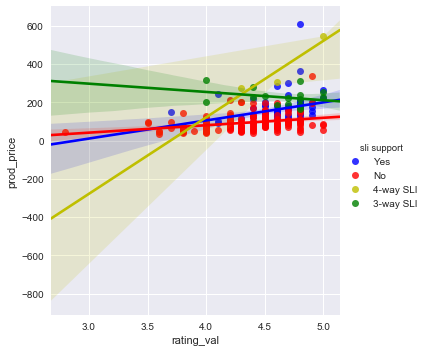

In [288]:
mobo_filtern = motherboard[motherboard['rating_n'] > 3]
sns.lmplot("rating_val", "prod_price", mobo_filtern, hue="sli support",
           palette={"Yes": "b", "No": "r", "3-way SLI": "g", "4-way SLI": "y"})

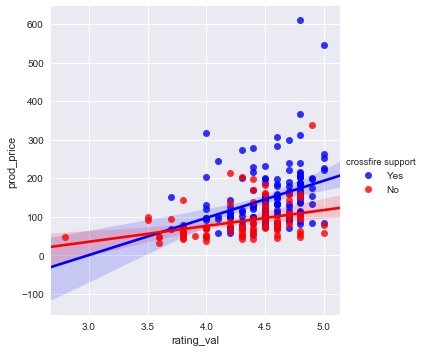

In [289]:
mobo_filtern = motherboard[motherboard['rating_n'] > 3]
sns.lmplot("rating_val", "prod_price", mobo_filtern, hue="crossfire support", palette={"Yes": "b", "No": "r"})

## 2. Determine interesting/restrictive values for Motherboards

In [290]:
#Print out some columns of interest:
print motherboard[['memory type', 'form factor',
                   'maximum supported memory', 'sli support',
                   'crossfire support', 'cpu socket',
                   'raid support', 'onboard ethernet',
                   'memory slots']].head()

                                         memory type form factor  \
1  DDR4-2133 / 2400 / 2666 / 2800 / 3000 / 3200 /...         ATX   
2       DDR4-1866 / 2133 / 2400 / 2666 / 2933 / 3200   Micro ATX   
3                                          DDR4-2133   Micro ATX   
4              DDR4-2133 / 2400 / 2800 / 3000 / 3200         ATX   
5                                   DDR4-2133 / 2400   Micro ATX   

  maximum supported memory sli support crossfire support cpu socket  \
1                     64GB         Yes               Yes    LGA1151   
2                     32GB          No                No        AM4   
3                     64GB          No                No    LGA1151   
4                     64GB         Yes               Yes    LGA1151   
5                     64GB          No                No    LGA1151   

  raid support      onboard ethernet      memory slots  
1          Yes  1 x 10/100/1000 Mbps  4 x 288-pin DIMM  
2          Yes  1 x 10/100/1000 Mbps  2 x 288-pin 

### Form factor (motherboard-case compatibility)

In [291]:
### We cleaned the case dataframe to make this easier!
print 'Unique values of "form factor" column from mobo:\n{}\n'.format(motherboard['form factor'].unique())
print 'Boolean columns from case dataframe:\n{}'.format(list(case.columns)[-6:-1])


Unique values of "form factor" column from mobo:
['ATX' 'Micro ATX' 'Mini ITX' 'EATX' 'SSI EEB']

Boolean columns from case dataframe:
['ATX compatibility', 'Micro ATX compatibility', 'Mini ITX compatibility', 'EATX compatibility', 'SSI EEB compatibility']


In [292]:
#Example filtering usage:
print '\nType of mother board:\n{}\n'.format(motherboard['form factor'][200])
print 'Subset of cases that are compatible:\n{}'.format(case[['prod_name', 'motherboard compatibility']][case['{} compatibility'.format(motherboard['form factor'][200])]].head())


Type of mother board:
EATX

Subset of cases that are compatible:
                                            prod_name  \
10                   Corsair 750D ATX Full Tower Case   
18            Corsair Carbide 400C ATX Mid Tower Case   
20                Inwin 909 BLACK ATX Full Tower Case   
22  Phanteks ECLIPSE P400 TEMPERED GLASS ATX Mid T...   
27           Phanteks ECLIPSE P400 ATX Mid Tower Case   

             motherboard compatibility  
10  ATX-EATX-Micro ATX-Mini ITX-XL ATX  
18         ATX-EATX-Micro ATX-Mini ITX  
20         ATX-EATX-Micro ATX-Mini ITX  
22         ATX-EATX-Micro ATX-Mini ITX  
27         ATX-EATX-Micro ATX-Mini ITX  


### Max memory (RAM): just need to strip GB from values

In [293]:
print 'Unique values of "maximum supported memory" column:\n{}\n'.format(motherboard['maximum supported memory'].unique())

#Look for GB and TB identifier, store the number value in the first group; store the unit in the second/third group
mobo_mem = [re.search('([0-9]+)(GB)?(TB)?', x) for x in motherboard['maximum supported memory']]

#Multiply by the appropriate conversion
motherboard['max mem int'] = [int(x.group(1))*2**10 if x.group(3)=='TB' else int(x.group(1)) for x in mobo_mem]

print 'Unique values of "max mem int" (converted) column:\n{}\n'.format(motherboard['max mem int'].unique())

Unique values of "maximum supported memory" column:
['64GB' '32GB' '128GB' '16GB' '1TB' '512GB' '8GB']

Unique values of "max mem int" (converted) column:
[  64   32  128   16 1024  512    8]



### Extract useful information from the onboard ethernet column

In [294]:
#The slashed values for this column actually indicate a range. The max value is all that's needed in practice
## The number of ports is also useful
print 'Unique values of "onboard ethernet" column:\n{}\n\n'.format(motherboard['onboard ethernet'].unique())

#Grab all of the values in the column
ethernet_list = [re.search('([0-9]) x ([0-9]*/)+([0-9]*) Mbps', x) for x in motherboard['onboard ethernet']]

#Example 1: standard 3 element slash
#Show all of the elements
print ethernet_list[1].group(0)
#Show the elements of interest
print [ethernet_list[1].group(1), ethernet_list[1].group(3)]
print '\n'

#Example 2: short onboard ethernet list
#Show all of the elements
print ethernet_list[82].group(0)
#Show the elements of interest
print [ethernet_list[82].group(1), ethernet_list[82].group(3)]

Unique values of "onboard ethernet" column:
['1 x 10/100/1000 Mbps' '2 x 10/100/1000 Mbps' '1 x 10/100 Mbps'
 '4 x 10/100/1000 Mbps']


1 x 10/100/1000 Mbps
['1', '1000']


1 x 10/100 Mbps
['1', '100']


In [295]:
#Assign these values to the dataframe:
### First, get the number of ports
motherboard['ethernet port n'] = [int(x.group(1)) for x in ethernet_list]

print 'Unique values for number of ports:\n{}\n'.format(motherboard['ethernet port n'].unique())

### Next, assign the max value for ethernet speed
motherboard['ethernet port lim'] = [int(x.group(3)) for x in ethernet_list]

print 'Unique values for speed limit, ethernet port:\n{}\n'.format(motherboard['ethernet port lim'].unique())

Unique values for number of ports:
[1 2 4]

Unique values for speed limit, ethernet port:
[1000  100]



### Extract number of CPUs and socket type allowed on MOBO

In [296]:
print 'Unique values of "cpu socket" column:\n{}\n'.format(motherboard['cpu socket'].unique())

#Search for required CPU-MOBO compatibility elements
mobo_cpu = [re.search('([0-9]+)?( x )?([A-Z]{1,3}[0-9]{1,4}\+?-?3?)', x) for x in motherboard['cpu socket']]

#Grab the number of supported CPUs per mobo
motherboard['cpu socket n'] = [1 if x.group(1) == None else int(x.group(1)) for x in mobo_cpu]
print 'Unique values of "cpu socket n" column:\n{}\n'.format(motherboard['cpu socket n'].unique())

Unique values of "cpu socket" column:
['LGA1151' 'AM4' 'AM3+' 'LGA2011-3' 'FM2+' 'LGA1150' 'AM3+/AM3' 'LGA1155'
 '2 x LGA2011-3' 'AM1' 'LGA2011-3 Narrow' '2 x LGA2011' 'FM2' 'AM3' 'FM1']

Unique values of "cpu socket n" column:
[1 2]



In [297]:
#Grab the type of supported CPUs for each mobo
motherboard['cpu socket type'] = [x.group(3) for x in mobo_cpu]
print 'Unique values of "cpu socket type" column:\n{}\n'.format(motherboard['cpu socket type'].unique())

Unique values of "cpu socket type" column:
['LGA1151' 'AM4' 'AM3+' 'LGA2011-3' 'FM2+' 'LGA1150' 'LGA1155' 'AM1'
 'LGA2011' 'FM2' 'AM3' 'FM1']



In [298]:
#For reference, here's the available socket types from the cpu dataframe
### These are strict compatibility requirements:
##### 1. must exactly match LGAs
##### 2. an AM or FM mobo with a + can handle both + and normal types
####### e.g. AM2+ mobo can handle AM2 or AM2+ cpu
print cpu['socket'].unique()

['LGA1151' 'AM4' 'AM3+' 'LGA2011-3' 'FM2+' 'LGA1150' 'LGA775' 'LGA1155'
 'FM2' 'AM2+-AM3' 'LGA2011' 'AM1' 'LGA1156' 'LGA1366' 'AM3']


In [299]:
def mobo_cpu_socket_bool(socket):
    if socket == 'AM2+-AM3':
        return motherboard['cpu socket type'] == 'AM3'
    else:
        x = re.search('([A-Z]{1,3}[0-9]{1,4}\+?-?3?)', socket)
        return motherboard['cpu socket type'] == x.group(0)

motherboard[mobo_cpu_socket_bool('AM2+-AM3')]

,manufacturer,part #,model,maximum supported memory,form factor,chipset,sli support,memory type,crossfire support,cpu socket,...,prod_type,rating_val,rating_n,prod_name,prod_price,max mem int,ethernet port n,ethernet port lim,cpu socket n,cpu socket type
436,Asus,M4A88TD-M/USB3,0,16GB,Micro ATX,AMD 880G,No,DDR3-1066 / 1333 / 1600 / 2000,Yes,AM3,...,Motherboard,5.0,1,Asus M4A88TD-M/USB3 Micro ATX AM3 Motherboard,125.25,16,1,1000,1,AM3


### Separate memory column in motherboard database into format and speed

In [300]:
# There is no overlap between DDR3 and DDR4 compatibility
print '5 values from "memory type" column:\n{}\n'.format(motherboard['memory type'][10:16])

5 values from "memory type" column:
11                              DDR4-2133 / 2400 / 2666
12    DDR4-2133 / 2400 / 2666 / 2800 / 3000 / 3200 /...
13    DDR4-2133 / 2400 / 2666 / 2800 / 3000 / 3200 /...
14                                            DDR4-2133
15                DDR4-2133 / 2400 / 2666 / 2933 / 3200
16                DDR3-1066 / 1333 / 1600 / 1866 / 2133
Name: memory type, dtype: object



In [301]:
### Getting the type is very easy (search for DDR# where # is what we want)
motherboard['DDR type'] = [int(re.search('^DDR([234])', x).group(1)) for x in motherboard['memory type']]
# We're half way done:
motherboard[['DDR type', 'memory type']].head(2)

,DDR type,memory type
1,4,DDR4-2133 / 2400 / 2666 / 2800 / 3000 / 3200 /...
2,4,DDR4-1866 / 2133 / 2400 / 2666 / 2933 / 3200


In [302]:
# Now work on extracting the speed compatibility
# Here is what the input will be
print memory['speed'][1:10]

2     DDR3-2133
3     DDR3-1600
4     DDR4-2133
5     DDR4-2666
6     DDR4-2666
7     DDR4-2400
8     DDR3-1600
9     DDR4-3200
10    DDR3-1600
Name: speed, dtype: object


In [303]:
#Take in RAM speed, type and output compatible mobos:
def mobo_ram_compatibility(mem_speed):
    mem_type = int(re.search('^DDR([234])', mem_speed).group(1))
    temp_bool_type = [mem_type == x for x in motherboard['DDR type']]
    
    mem_n = re.search('([0-9]{2,4})', mem_speed).group(1)
    temp_bool_n = [(mem_n in x) for x in motherboard['memory type']]
    return ([a and b for a, b in zip(temp_bool_type, temp_bool_n)])

#Example usage with specific speed (from memory['speed'])
motherboard[mobo_ram_compatibility('DDR4-1600')].head(3)

,manufacturer,part #,model,maximum supported memory,form factor,chipset,sli support,memory type,crossfire support,cpu socket,...,rating_val,rating_n,prod_name,prod_price,max mem int,ethernet port n,ethernet port lim,cpu socket n,cpu socket type,DDR type
89,Asus,Z10PE-D16 WS,0,1TB,SSI EEB,Intel C612,3-way SLI,DDR4-1600 / 1866 / 2133 / 2400,Yes,2 x LGA2011-3,...,5.0,1,Asus Z10PE-D16 WS SSI EEB Dual-CPU LGA2011-3 M...,461.98,1024,2,1000,2,LGA2011-3,4
121,Supermicro,MBD-X10DAX,0,1TB,EATX,Intel C612,3-way SLI,DDR4-1600 / 1866 / 2133 / 2400,Yes,2 x LGA2011-3,...,5.0,1,Supermicro MBD-X10DAX EATX Dual-CPU LGA2011-3 ...,439.71,1024,2,1000,2,LGA2011-3,4
143,ASRock,X99X Killer,Fatal1ty X99X Killer,128GB,ATX,Intel X99,3-way SLI,DDR4-1600 / 1866 / 2133 / 2400 / 2666 / 2800 /...,Yes,LGA2011-3,...,5.0,6,ASRock Fatal1ty X99X Killer ATX LGA2011-3 Moth...,226.97,128,2,1000,1,LGA2011-3,4


In [304]:
print 'Type of first four memory sticks\n{}'.format(memory['speed'][0:4])
print '\n'
print 'Number of compatible mobos for first four memory sticks:\n{}'.format([len(motherboard[mobo_ram_compatibility(x)]) for x in memory['speed']][0:4])

Type of first four memory sticks
1    DDR3-1333
2    DDR3-2133
3    DDR3-1600
4    DDR4-2133
Name: speed, dtype: object


Number of compatible mobos for first four memory sticks:
[193, 79, 186, 256]


### Convert sli and crossfire support to max numerical variable (as we did for GPU)

#### Can use the function sli_cross_num for both cases

In [305]:
print 'Choices for sli support:\n{}\n'.format(motherboard['sli support'].unique())
print 'Choices for crossfire support:\n{}'.format(motherboard['crossfire support'].unique())

Choices for sli support:
['Yes' 'No' '4-way SLI' '3-way SLI']

Choices for crossfire support:
['Yes' 'No']


In [306]:
#Convert from text to number of gpus allowed (sli or crossfire) and store the max of the two numbers
motherboard['max gpus'] = map(lambda x: max([x[0],x[1]]),
                              zip(sli_cross_num(motherboard, 'sli support'),
                                  sli_cross_num(motherboard, 'crossfire support')))

motherboard[['max gpus', 'crossfire support', 'sli support']][21:26]

,max gpus,crossfire support,sli support
22,4,Yes,4-way SLI
23,2,Yes,Yes
24,2,Yes,No
25,2,Yes,Yes
26,1,No,No


## 3. New data analysis with updated columns

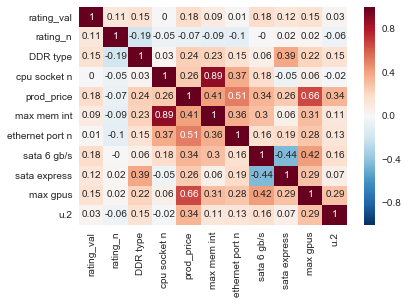

In [307]:
sns.heatmap(motherboard[['rating_val', 'rating_n',
                         'DDR type', 'cpu socket n',
                         'prod_price', 'max mem int',
                         'memory slots', 'ethernet port n',
                         'sata 6 gb/s', 'sata express',
                         'onboard usb 3.0 header(s)', 'max gpus', 'u.2']].corr().round(2), annot=True)

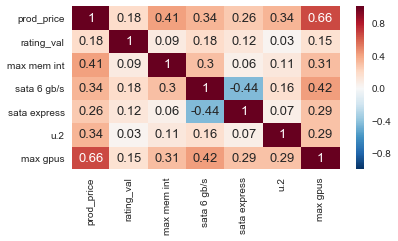

In [497]:
plt.figure(figsize=(6, 3))
sns.heatmap(motherboard[['prod_price','rating_val',
                         'max mem int',
                         'sata 6 gb/s', 'sata express',
                         'onboard usb 3.0 header(s)', 'u.2', 'max gpus'
                ]].corr().round(2), annot=True, annot_kws={"size": 13})

# PSU dataframe cleaning and organizing

## 1. PSU rating and price plot

In [308]:
psu.head(2)

,manufacturer,part #,type,model,wattage,modular,efficiency,efficiency certification,output,pci-express 6+2-pin connectors,...,prod_type,rating_val,rating_n,prod_name,prod_price,Micro ATX compatibility,Mini ITX compatibility,EATX compatibility,ATX compatibility,rating str
1,EVGA,120-G1-0650-XR,ATX12V / EPS12V,SuperNOVA 650,650 Watts,Full,90% Typical,80+ Gold,+3.3V@25A-+5V@25A-+12V1@20A-+12V2@20A-+12V3@20...,4.0,...,Power Supply,4.7,194,EVGA SuperNOVA NEX 650W 80+ Gold Certified Ful...,74.88,True,False,True,True,Gold
2,EVGA,100-B1-0500-KR,ATX12V / EPS12V,500B,500 Watts,No,< 85%,80+ Bronze,0,2.0,...,Power Supply,4.5,147,EVGA 500W 80+ Bronze Certified ATX Power Supply,36.87,True,False,True,True,Bronze


In [309]:
print psu.columns

Index([u'manufacturer', u'part #', u'type', u'model', u'wattage', u'modular',
       u'efficiency', u'efficiency certification', u'output',
       u'pci-express 6+2-pin connectors', u'fans', u'prod_type', u'rating_val',
       u'rating_n', u'prod_name', u'prod_price', u'Micro ATX compatibility',
       u'Mini ITX compatibility', u'EATX compatibility', u'ATX compatibility',
       u'rating str'],
      dtype='object')


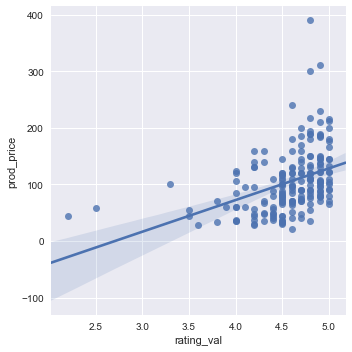

In [310]:
psu_filtern = psu[psu['rating_n'] > 3]
sns.lmplot("rating_val", "prod_price", psu_filtern)

## 2. Cleaning PSU specs for use

### Strip out Watts from Wattage column

In [311]:
psu['wattage'].unique()

array(['650 Watts', '500 Watts', '450 Watts', '750 Watts', '850 Watts',
       '550 Watts', '430 Watts', '520 Watts', '600 Watts', '1000 Watts',
       '1500 Watts', '1200 Watts', '700 Watts', '620 Watts', '400 Watts',
       '1600 Watts', '760 Watts', '860 Watts', '480 Watts', '300 Watts',
       '1300 Watts', '350 Watts', '660 Watts', '1050 Watts', '380 Watts',
       '530 Watts', '220 Watts', '800 Watts', '680 Watts', '1250 Watts',
       '1475 Watts', '360 Watts', '575 Watts', '460 Watts', '585 Watts',
       '900 Watts', '1275 Watts', '525 Watts', '250 Watts', '485 Watts',
       '950 Watts'], dtype=object)

In [312]:
psu['watt n'] = [int(re.search('[0-9]{1,4}', x).group(0)) for x in psu['wattage']]

psu[['watt n', 'wattage']].head(3)

,watt n,wattage
1,650,650 Watts
2,500,500 Watts
3,450,450 Watts


### Motherboard-PSU compatibility definitions and functions

In [313]:
##### Looking at motherboard-PSU compatibility #####

#Format of relations is PSU: motherboard compatibility
# ATX: ATX, microATX
# SFX: microATX, miniITX
# EPS: ATX, EATX
# TFX: microATX, MiniITX
# Flex ATX: microATX, MiniITX
# Micro and mini entries mapped to themselves only
### Convert the above to a dictionary ###

psu_mobo_dict = {'Micro ATX':['Micro ATX'],
                 'Mini ITX':['Mini ITX'],
                 'ATX':['ATX', 'Micro ATX'], 
                 'SFX':['Micro ATX', 'Mini ITX'], 
                 'EPS':['ATX', 'EATX'],
                 'TFX':['Micro ATX', 'Mini ITX'],
                 'Flex ATX':['Micro ATX', 'Mini ITX']}

mobo_psu_dict = {'Micro ATX':['Micro ATX', 'ATX', 'SFX', 'TFX', 'Flex ATX'],
                 'Mini ITX':['Mini ITX', 'SFX', 'TFX', 'Flex ATX'],
                 'ATX':['ATX', 'EPS'],
                 'EATX':['EPS']}

## Example usage ##
# Choice of Motherboard type
mobo_type = 'Mini ITX'
print 'Choice of mobo type:\n{}\n'.format(mobo_type)

# Compatible PSU types
print 'Compatible PSU types:\n{}\n'.format(mobo_psu_dict[mobo_type])

psu_type1 = [re.search('([A-Za-z]{1,5})(12V\s/\s)?([A-Za-z]{1,5})?', x).group(1) for x in psu['type']]

psu_type2 = []
for i in range(1, len(psu['type'])+1):
    try:
        psu_type2.append(str(re.search('([A-Za-z]{1,5})(12V\s/\s)?([A-Za-z]{1,5})?', psu['type'][i]).group(3)))
    except: 
        psu_type2.append('')

# Search for all compatible mobos
def mobo_psu_bool(mobo_type):
    psu_comps = mobo_psu_dict[mobo_type]
    for i in range(0, len(psu_comps)):
        bool1 = [bool(re.match(psu_comps[i], x)) for x in psu_type1]
        bool2 = [bool(re.match(psu_comps[i], x)) for x in psu_type2]
        run_bool = [a or b for a, b in zip(bool1, bool2)]
        
        if i > 0:
            run_bool = [a or b for a, b in zip(run_bool, temp_bool)]
        
        temp_bool = run_bool[:]

    return run_bool

print 'A few compatible PSU\'s for this Mobo:'
psu[mobo_psu_bool(mobo_type)].tail()

Choice of mobo type:
Mini ITX

Compatible PSU types:
['Mini ITX', 'SFX', 'TFX', 'Flex ATX']

A few compatible PSU's for this Mobo:


,manufacturer,part #,type,model,wattage,modular,efficiency,efficiency certification,output,pci-express 6+2-pin connectors,...,rating_val,rating_n,prod_name,prod_price,Micro ATX compatibility,Mini ITX compatibility,EATX compatibility,ATX compatibility,rating str,watt n
67,Silverstone,SST-SX600-G,SFX12V,SX600-G,600 Watts,Full,0,80+ Gold,0,2.0,...,4.5,10,Silverstone 600W 80+ Gold Certified Fully-Modu...,116.98,True,True,False,False,Gold,600
110,Silverstone,SX700-LPT,SFX12V,0,700 Watts,Full,89% ~ 92% at 20% ~ 100% loading,80+ Platinum,+3.3V@22A-+5V@22A-+12V@58.4A-+5VSB@3.0A--12V@0.3A,4.0,...,5.0,3,Silverstone 700W 80+ Platinum Certified Fully-...,144.98,True,True,False,False,Platinum,700
243,SeaSonic,SS-300TFX Bronze,TFX12V,0,300 Watts,No,> 82%,80+ Bronze,0,0.0,...,5.0,1,SeaSonic 300W 80+ Bronze Certified TFX Power S...,41.97,True,True,False,False,Bronze,300
326,Apex,AL-8250SFX,SFX12V,0,250 Watts,No,> 65%,0,+3.3V@14A-+5V@12A-+12V@16A--12V@0.3A-+5VSB@2.0A,0.0,...,2.5,2,Apex 250W SFX Power Supply,22.97,True,True,False,False,Unknown,250
346,FSP Group,FSP300-60SGV,TFX12V,0,300 Watts,No,> 90%,80+ Gold,0,0.0,...,5.0,1,FSP Group 300W 80+ Gold Certified TFX Power Su...,49.98,True,True,False,False,Gold,300


In [314]:
#Assign compatibility to dataframe
for mobo in mobo_psu_dict.keys():
    psu['{} compatibility'.format(mobo)] = mobo_psu_bool(mobo)
    print psu['{} compatibility'.format(mobo)].head(1)

1    True
Name: Micro ATX compatibility, dtype: bool
1    False
Name: Mini ITX compatibility, dtype: bool
1    True
Name: EATX compatibility, dtype: bool
1    True
Name: ATX compatibility, dtype: bool


In [315]:
power_rating = []

for efficiency in psu['efficiency certification']:
    try:
        output = re.search('80\+\s?([A-Za-z]+)?', efficiency).group(1)
        if output == None:
            power_rating.append('Basic')
        else:
            power_rating.append(output)
    except:
        power_rating.append('Unknown')
    
psu['rating str'] = power_rating
psu[['efficiency certification', 'rating str']][3:7]
psu['rating str'].unique()

array(['Gold', 'Bronze', 'Basic', 'Platinum', 'Titanium', 'Unknown',
       'Silver'], dtype=object)

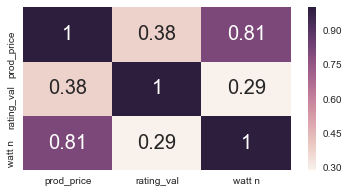

In [422]:
plt.figure(figsize=(6, 3))
sns.heatmap(psu[['prod_price','rating_val',
                 'watt n'
                ]].corr().round(2), annot=True, annot_kws={"size": 20})

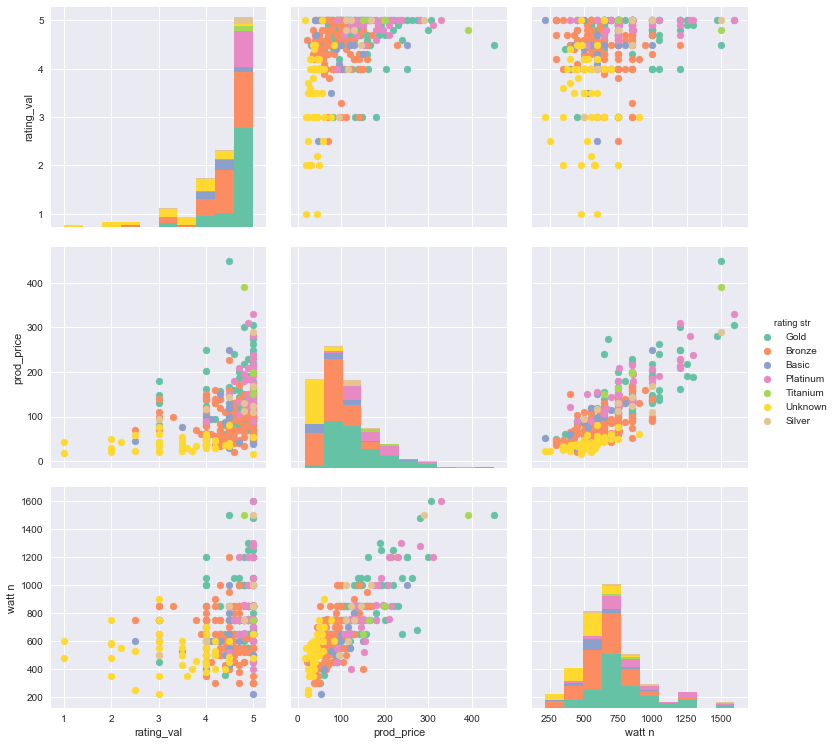

In [504]:
g = sns.PairGrid(psu[['rating_val', 'prod_price', 'watt n', 'rating str']], hue='rating str', palette='Set2', size = 3.5)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

# Storage dataframe cleaning and organizing

## 1. Storage specs with respect to rating and price

In [435]:
storage.columns

Index([u'manufacturer', u'part #', u'model', u'capacity', u'interface',
       u'form factor', u'price/gb', u'prod_type', u'rating_val', u'rating_n',
       u'prod_name', u'prod_price', u'cache', u'nand flash type'],
      dtype='object')

In [436]:
for el in ['capacity', 'interface', 'form factor', 'cache', 'nand flash type']:
    print 'Unique values of {}:\n{}\n'.format(el, storage[el].unique())

Unique values of capacity:
['480GB' '750GB' '256GB' '240GB' '120GB' '4TB' '500GB' '8TB' '2TB' '1TB'
 '250GB' '6TB' '512GB' '320GB' '960GB' '400GB' '128GB' '3TB' '60GB' '600GB'
 '64GB' '160GB' '5TB' '800GB' '300GB' '80GB' '450GB' '40GB' '1.5TB' '180GB'
 '100GB' '640GB' '90GB']

Unique values of interface:
['SATA 6 Gb/s' 'SATA 3 Gb/s' 'M.2 (M)' 'M.2 (B+M)' 'PCI-Express x4'
 'U.2 (SFF-8639)' 'PATA 100' 'mSATA' 'SATA 1.5 Gb/s']

Unique values of form factor:
[' 2.5""' ' 3.5""' 'M.2-2280' 'PCI-E' 'mSATA' 'M.2-2242']

Unique values of cache:
[0 '16MB' '512MB' '64MB' '32MB' '128MB' '8MB' '256MB']

Unique values of nand flash type:
[' ' ' TLC (toggle)' ' MLC (toggle)' ' MLC (synchronous)' ' Varies' ' MLC'
 ' MLC (asynchronous)' ' HET MLC']



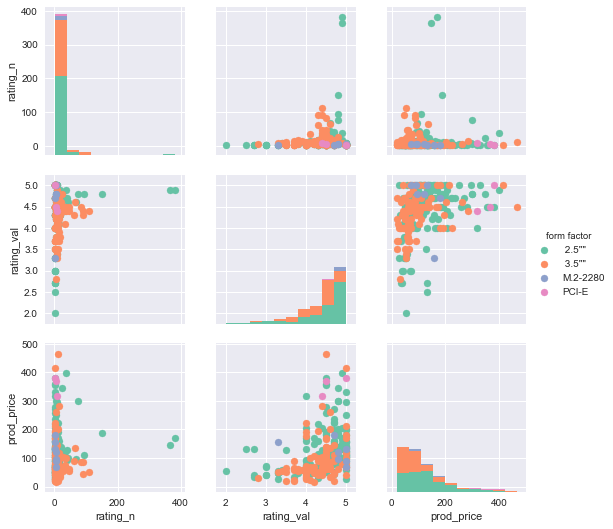

In [437]:
storage_filter = storage[storage['rating_n'] > 1]
g = sns.PairGrid(storage_filter[['rating_n', 'rating_val', 'prod_price', 'form factor']], hue='form factor', palette='Set2')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

## 2. Cleaning Storage specs for ease of use

### Convert all capacity values to same unit (GB) and make numeric

In [446]:
# Grab all of the data out of the capacity column
capacity = [re.search('([0-9]{1,3}\.?[0-9]?)([A-Za-z]{1,2})', storage['capacity'][x]) for x in range(1, storage.shape[0]+1)]

#Grab the value first
capacity_val = [float(capacity[x].group(1)) for x in range(0, storage.shape[0])]
#And then the data type
capacity_type = [str(capacity[x].group(2)) for x in range(0, storage.shape[0])]

#Convert MB to KB
capacity_val = [float(capacity[x].group(1)) if str(capacity[x].group(2)) == 'GB' else float(capacity[x].group(1))*2**10 for x in range(0, storage.shape[0])]

#Assign values to dataframe
storage['capacity total'] = capacity_val
storage.sort_values(by='capacity total', ascending=False).head(2)

storage['prod_price'] = storage['prod_price'][storage['prod_price'] > 0]
storage = storage[storage['price/gb']!=0]

### Look at the storage interface types

In [447]:
storage['interface'].unique()

array(['SATA 6 Gb/s', 'SATA 3 Gb/s', 'M.2 (M)', 'M.2 (B+M)',
       'PCI-Express x4', 'U.2 (SFF-8639)', 'PATA 100', 'mSATA',
       'SATA 1.5 Gb/s'], dtype=object)

In [448]:
#Assign boolean column for most frequently used interface: SATA
storage['SATA compatible'] = [bool(re.search('SATA', x)) for x in storage['interface']]

In [449]:
#Strip out the parenth'd part of 'U.2 (SFF-8639)' and conver U to lower
storage['interface'] = [re.sub('(\s\(SFF-8639\))','', x) for x in storage['interface']]
storage['interface'] = [re.sub('U.2','u.2', x) for x in storage['interface']]

In [450]:
#Likewise for the M.2 entries
storage['interface'] = [re.sub('(\s\(SFF-8639\))','', x) for x in storage['interface']]
storage['interface'] = [re.sub('U.2','u.2', x) for x in storage['interface']]

In [451]:
storage[['interface']].head()

,interface
1,SATA 6 Gb/s
2,SATA 3 Gb/s
3,SATA 6 Gb/s
4,SATA 6 Gb/s
5,M.2 (M)


In [452]:
motherboard[['sata 6 gb/s','sata express', 'u.2']].sort_values(ascending=False, by=['u.2', 'sata express']).head()

,sata 6 gb/s,sata express,u.2
61,8.0,1.0,2.0
100,8.0,1.0,2.0
174,8.0,0.0,2.0
40,4.0,2.0,1.0
269,2.0,2.0,1.0


### Search for 2.5 and 3.5 form factors for compatibility with case

In [453]:
storage['2.5in form'] = [bool(re.search('2\.5', x)) for x in storage['form factor']]
storage['3.5in form'] = [bool(re.search('3\.5', x)) for x in storage['form factor']]

In [454]:
storage[storage['2.5in form']].head(1)

,manufacturer,part #,model,capacity,interface,form factor,price/gb,prod_type,rating_val,rating_n,prod_name,prod_price,cache,nand flash type,capacity total,SATA compatible,2.5in form,3.5in form
1,ADATA,ASP550SS3-480GM-C,0,480GB,SATA 6 Gb/s,"2.5""""",$0.28,Storage,4.7,3,"ADATA Premier SP550 480GB 2.5"""" Solid State Drive",134.48,0,,480.0,True,True,False


### Strip dollar sign out of price/gb

In [465]:
#Dollar sign is always first character, slice it off with list comprehension
storage['price/gb'] = [x[1:] for x in storage['price/gb']]

## 3. Correlation heatmaps for Storage

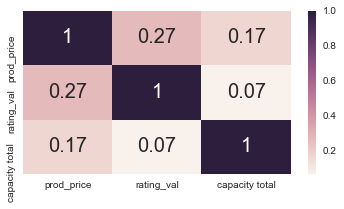

In [459]:
plt.figure(figsize=(6, 3))
sns.heatmap(storage[['prod_price','rating_val',
                 'capacity total'
                ]].corr().round(2), annot=True, annot_kws={"size": 20})

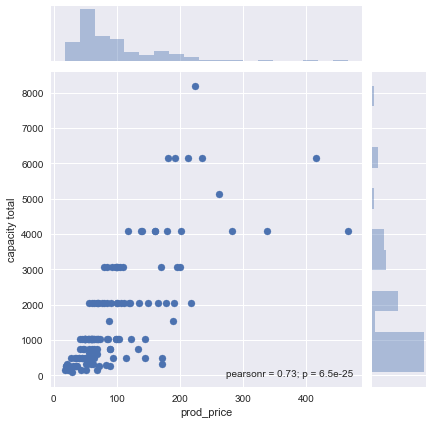

In [476]:
storage_filter = storage[storage['3.5in form'] == True]
sns.jointplot("prod_price", "capacity total", storage_filter)

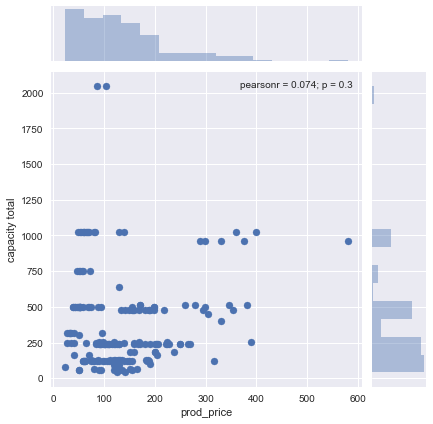

In [477]:
storage_filter = storage[storage['2.5in form'] == True]
sns.jointplot("prod_price", "capacity total", storage_filter)

# Final write of modified data files (currently using SQLite3)

In [876]:
from sqlalchemy import create_engine
#Create engine, write with to_sql pandas dataframe method for each dataframe
db_engine = create_engine('sqlite:///pcpart.db')

for el in ['case', 'cpu', 'cooler', 'gpu', 'memory', 'motherboard', 'psu', 'storage']:
    eval(el).to_sql('{}_table'.format(el), db_engine, if_exists='replace')


In [179]:
from sqlalchemy import create_engine
db_engine = create_engine('sqlite:///pcpart.db')
motherboard.to_sql('motherboard_table', db_engine, if_exists='replace')

In [35]:
import sqlite3

con = sqlite3.connect('pcpart.db')
cursor = con.cursor()

#Code to print out all available tables in our database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print cursor.fetchall()

[(u'case_table',), (u'cpu_table',), (u'cooler_table',), (u'memory_table',), (u'motherboard_table',), (u'psu_table',), (u'storage_table',), (u'gpu_table',)]


In [880]:
#Example read from Storage table in database
df = pd.read_sql_query("SELECT prod_name as name,"
                       "prod_price as price,"
                       "`capacity total` as capacity "
                       "FROM storage_table "
                       "WHERE `2.5in form` = 1 "
                       "AND `price/gb` < 0.5 "
                       "ORDER BY `price/gb`", con)
df.head()

,name,price,capacity
0,"Seagate BarraCuda 2TB 2.5"""" 5400RPM Internal H...",86.98,2048.0
1,"Samsung Spinpoint M9T 2TB 2.5"""" 5400RPM Intern...",104.49,2048.0
2,"Toshiba 1TB 2.5"""" 5400RPM Internal Hard Drive",48.98,1024.0
3,"Seagate Momentus 1TB 2.5"""" 5400RPM Internal Ha...",52.89,1024.0
4,"Seagate BarraCuda 1TB 2.5"""" 5400RPM Internal H...",54.87,1024.0
